In [1]:
import data.loader as loader
import models.transformers.blip as blip
import models.transformers.vilt as vilt
import util.data_util as dutil
import attention.human_heatmaps as hmaps
from util.image import fuze_image_and_array, resize_array_to_img
from attention.hooks import EncapsulateTransformerAttention, EncapsulateTransformerActivationAndGradients
from attention.attention_rollout import attention_rollout
from attention.grad_cam import compute_grad_cam_for_layers
from compute_performance import get_mean_performance_reasoning_types, append_reasoning_type_to_df
from eval.heatmap_comparison_metrics import auc_judd, kl_divergence, rank_correlation, nss, new_kl_div
import attention.human_heatmaps as hmaps
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.stats
from statsmodels.formula.api import ols

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

COLORS = {
    "RED": "#b90f22",
    "BLUE": "#29339b",
    "VIOLET": "#69306d",
    "GREEN": "#007540",
    "ORANGE": "#ffbc42"
}

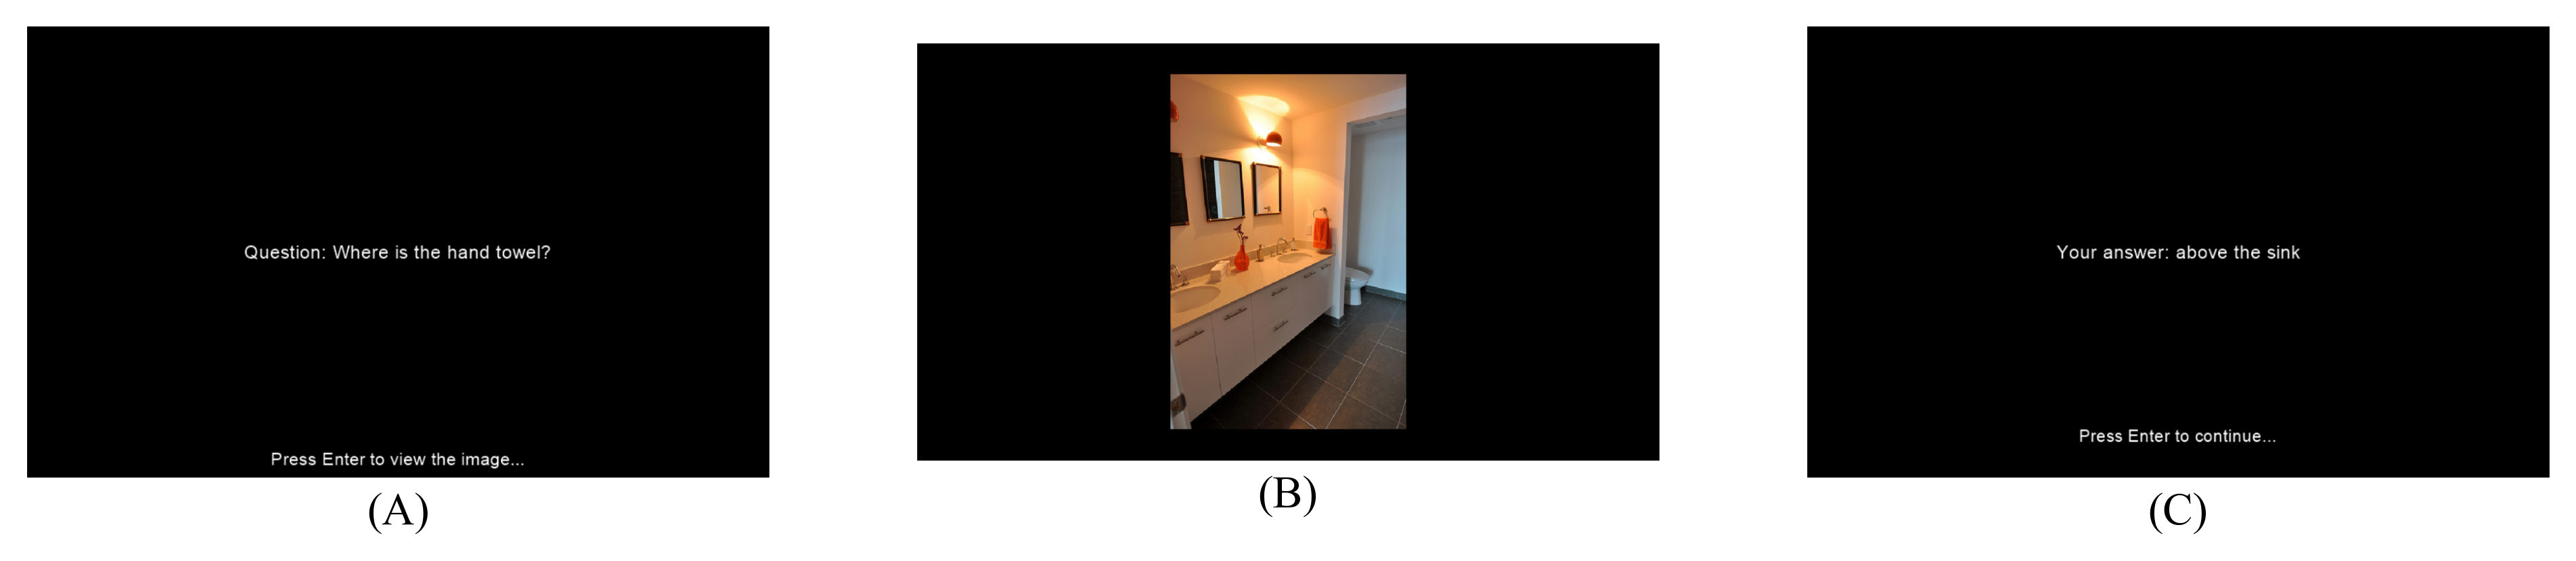

In [21]:
from PIL import Image

img0 = Image.open(r"C:/Users/bock-/Pictures/Screenshots/s1.png")
img1 = Image.open(r"C:\Users\bock-\Pictures\Screenshots\s2.png")
img2 = Image.open(r"C:\Users\bock-\Pictures\Screenshots\s3.png")

fig, axes = plt.subplots(1, 3, figsize=(12, 6), dpi=400) #figsize=(10, 3)
(ax1, ax2, ax3) = axes
ax1.imshow(np.asarray(img0)[200:-200, 400:-400])
ax1.set_xlabel("(A)", size=12)
ax2.imshow(img1)
ax2.set_xlabel("(B)", size=12)
ax3.imshow(np.asarray(img2)[200:-200, 400:-400])
ax3.set_xlabel("(C)", size=12)

for ax in axes:
    ax.axis("tight")  # gets rid of white border
    ax.axis("image")  # square up the image instead of filling the "figure" space
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
plt.savefig("outputs/plots/experiment_setup.pdf", bbox_inches="tight")

In [2]:
att_rollout_dict, grad_cam_dict, answer_df = loader.load_model_results("blip")
gaze_df, event_df, logger_df = loader.load_participant_data()

question_ids = logger_df["question_id"].value_counts().index.tolist()

# Load in all data
images = loader.load_images(question_ids)
questions = loader.load_questions(question_ids)
valid_fixations = dutil.get_fixation_df(event_df)

FileNotFoundError: [Errno 2] No such file or directory: 'F:\\Content\\Bachelorarbeit\\data\\vqav2\\images\\val2014\\COCO_val2014_000000175718.jpg'

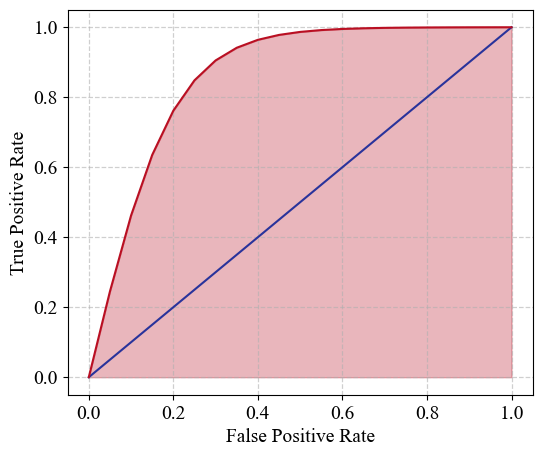

In [6]:
fig, ax = plt.subplots(1,1, figsize=(6,5))
ax.grid(True, linestyle='--', linewidth=0.9, alpha=0.6, zorder=-1)
ax.plot([0, 1], [0, 1], label="Chance Classifier", color=COLORS["BLUE"], zorder=2)
x = list(np.arange(0, 1, 0.05))
x.append(1)
y = np.tanh(np.array(x) * 5)
ax.plot(x, y, label="Exemplary Classifier", color=COLORS["RED"], zorder=3)
ax.fill_between(x,y, color=COLORS["RED"], alpha=0.3, label="AUROC", zorder=1)
plt.xlabel("False Positive Rate")
# plt.legend(loc="upper right")
plt.ylabel("True Positive Rate")
plt.savefig("outputs/plots/auroc.pdf")

In [25]:
q_idx = 8
q_id = question_ids[q_idx]

# Get high res
logger_slice = logger_df[logger_df["question_id"] == q_id]
x_min, x_max, y_min, y_max = logger_slice[["bb_image_x_min", "bb_image_x_max", "bb_image_y_min", "bb_image_y_max"]].values[0]
resized_img = images[q_idx].resize((x_max - x_min, y_max - y_min))
human_map = hmaps.create_gaussian_human_heatmap(valid_fixations, logger_df, q_id, reduction=np.mean)
human_map = resize_array_to_img(images[q_idx], human_map)
fuzed_highres = fuze_image_and_array(images[q_idx], human_map)

# Get low res 
att_rollout_heatmap = att_rollout_dict[str(q_id)]
low_res_heatmap = hmaps.compute_low_res_human_heatmap(valid_fixations, logger_df, q_id, att_map_shape=att_rollout_heatmap.shape, reduction=np.mean)
resized_map = resize_array_to_img(images[q_idx], low_res_heatmap)

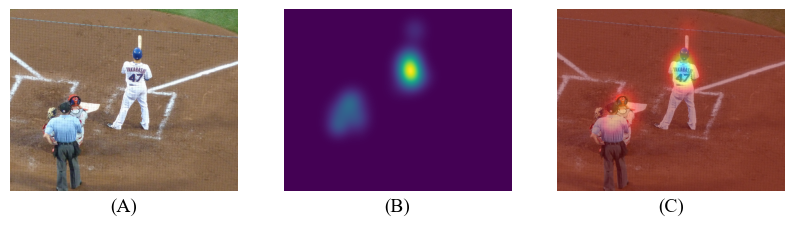

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3)) #figsize=(10, 3)
(ax1, ax2, ax3) = axes
ax1.imshow(images[q_idx])
ax1.set_xlabel("(A)")
ax2.imshow(human_map)
ax2.set_xlabel("(B)")
ax3.imshow(fuzed_highres)
ax3.set_xlabel("(C)")

for ax in axes:
    ax.axis("tight")  # gets rid of white border
    ax.axis("image")  # square up the image instead of filling the "figure" space
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
plt.savefig("outputs/plots/gaussian_heatmaps.pdf", bbox_inches="tight")

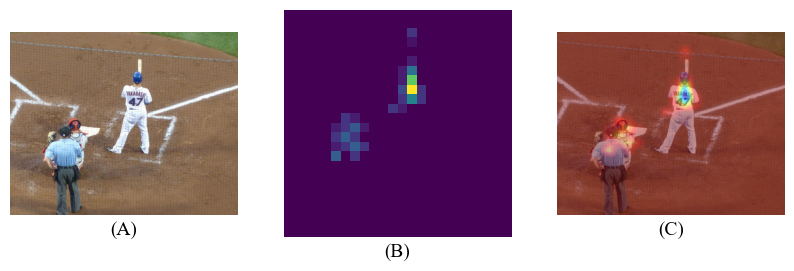

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3)) #figsize=(10, 3)
(ax1, ax2, ax3) = axes
ax1.imshow(images[q_idx])
ax1.set_xlabel("(A)")
ax2.imshow(low_res_heatmap)
ax2.set_xlabel("(B)")
ax3.imshow(fuze_image_and_array(images[q_idx], resized_map * 1.5))
ax3.set_xlabel("(C)")

for ax in axes:
    ax.axis("tight")  # gets rid of white border
    ax.axis("image")  # square up the image instead of filling the "figure" space
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
plt.savefig("outputs/plots/low_res_heatmaps.pdf", bbox_inches="tight")

### Transformer Heatmap generation

In [6]:
processor = blip.load_processor()
model = blip.load_model()

encapsulated_model = EncapsulateTransformerAttention(
    model,
    blip.CONFIG["ATTENTION_LAYER_HOOK_NAME"],
    unsqueeze_attentions=blip.CONFIG["UNSQUEEZE_ATTENTIONS"],
    model_wrapper_used=blip.CONFIG["MODEL_WRAPPER_USED"]
)

# Preprocess the data for the model
q_idx = 8
q_id = question_ids[q_idx]
question = questions[q_idx]
image_eval = images[q_idx]
answer = loader.load_annotated_answers([q_id], single_answer=True)
answer = list(answer.values())[0]
model_input = blip.preprocess(processor, question, answer, image_eval)

# Inference / Forward: Get output and attentions from the encapsulated model
output, attentions = encapsulated_model(**model_input)

# Get model answers: Some of these parameters might not be necessary, but for consistency across models needed
processed_outp = blip.process_output(
    model,
    processor,
    **output,
    **model_input
)

In [22]:
# Get the textual embedding length for the given model
text_embedding_len = blip.get_textual_embedding_length(model_input)

# Get the amount of patches in each dimension for the given image + model
amount_image_patches = blip.get_amount_of_image_patches(model_input)

# Get heatmap(s) for model attention
rollout_attention_map = attention_rollout(
    atts=attentions,
    image_patch_embedding_retrieval_fct=blip.image_patch_embedding_retrieval_fct if text_embedding_len > 0 else None,
    text_embed_length=text_embedding_len,
    amount_image_patches=amount_image_patches,
    head_fusion="max"
)

resized_att_rollout_map = resize_array_to_img(images[q_idx], low_res_heatmap)

# Get simple attention matrices
attentions = [x.detach().clone() for x in attentions]
masks = []
for idx in [0, 2, 3, 4]:
    attention_heads_fused = attentions[idx].min(axis=1)[0][0, 0, 1:]
    
    # Get amount of image patches
    amt_patches_height, amt_patches_width = amount_image_patches

    # Reshape the vector to a amt_patches_height x amt_patches_width image (heatmap)
    masks.append(attention_heads_fused.reshape(amt_patches_height, amt_patches_width).numpy())

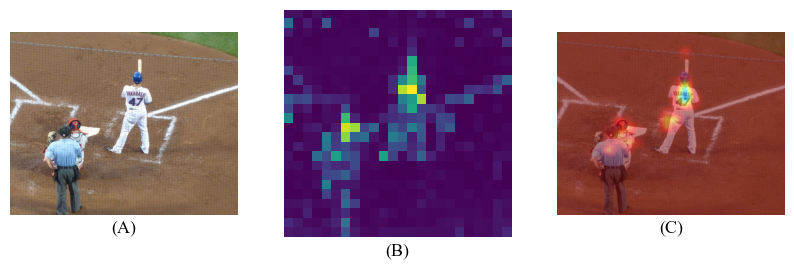

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3)) #figsize=(10, 3)
(ax1, ax2, ax3) = axes
ax1.imshow(images[q_idx])
ax1.set_xlabel("(A)")
ax2.imshow(rollout_attention_map)
ax2.set_xlabel("(B)")
ax3.imshow(fuze_image_and_array(images[q_idx], resized_att_rollout_map * 1.25))
ax3.set_xlabel("(C)")

for ax in axes:
    ax.axis("tight")  # gets rid of white border
    ax.axis("image")  # square up the image instead of filling the "figure" space
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
plt.savefig("outputs/plots/att_rollout_example.pdf")

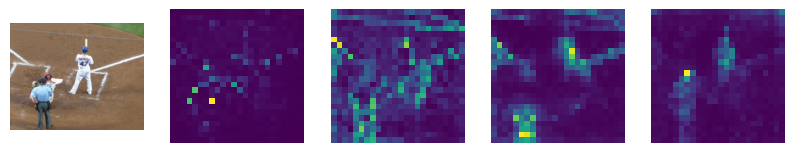

In [51]:
fig, axes = plt.subplots(1, 5, figsize=(10, 3)) #figsize=(10, 3)
for idx, ax in enumerate(masks):
    axes[idx+1].imshow(masks[idx])
axes[0].imshow(images[q_idx])
for ax in axes:
    ax.axis("tight")  # gets rid of white border
    ax.axis("image")  # square up the image instead of filling the "figure" space
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.savefig("outputs/plots/attention_layer_example.pdf", bbox_inches="tight")

In [59]:
processor = vilt.load_processor()
model = vilt.load_model()

# Encapsulated model for the gradients and activations of the target layers
encapsulated_gradient_model = EncapsulateTransformerActivationAndGradients(model, eval(
    vilt.CONFIG["GRAD_LAYERS_HOOK_LIST"]
))

# Preprocess the data for the model
model_input = vilt.preprocess(processor, question, answer, image_eval)

# Inference: Get activations and gradients w.r.t. the predicted output class
encapsulated_gradient_model(**model_input)

# Get the textual embedding length for the given model
text_embedding_len = vilt.get_textual_embedding_length(model_input)

# Get the amount of patches in each dimension for the given image + model
amount_image_patches = vilt.get_amount_of_image_patches(model_input)

# For now, we only take the first one of the registered layers (only really one necessary)
grad_cam_heatmap = compute_grad_cam_for_layers(
    encapsulated_gradient_model.gradients,
    encapsulated_gradient_model.activations,
    text_embed_length=text_embedding_len,
    amount_image_patches=amount_image_patches,
    image_patch_embedding_retrieval_fct=vilt.image_patch_embedding_retrieval_fct_for_gradients if text_embedding_len > 0 else None,
)[0]

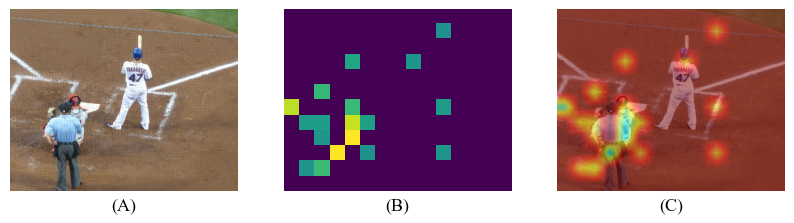

In [101]:
transformed_img = np.vectorize(lambda x: 0 if x <= 0.5 else x)(grad_cam_heatmap)
def shift(arr, num, fill_value=np.nan):
    arr = np.roll(arr,num)
    if num < 0:
        arr[num:] = fill_value
    elif num > 0:
        arr[:num] = fill_value
    return arr
transformed_img = shift(transformed_img, -1, 0)
transformed_img[:, 11:] = 0
resized_grad_cam_map = resize_array_to_img(images[q_idx], transformed_img)

fig, axes = plt.subplots(1, 3, figsize=(10, 3)) #figsize=(10, 3)
(ax1, ax2, ax3) = axes
ax1.imshow(images[q_idx])
ax1.set_xlabel("(A)")
ax2.imshow(transformed_img)
ax2.set_xlabel("(B)")
ax3.imshow(fuze_image_and_array(images[q_idx], resized_grad_cam_map * 0.65))
ax3.set_xlabel("(C)")

for ax in axes:
    ax.axis("tight")  # gets rid of white border
    ax.axis("image")  # square up the image instead of filling the "figure" space
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
plt.savefig("outputs/plots/grad_cam_example.pdf")

### Reasoning types

In [43]:
reasoning_type_dict = loader.load_annotated_reasoning_types()

question_ids = loader.load_experiment_questions_for_group(1)
question_ids.extend(loader.load_experiment_questions_for_group(2))

mapped = {}

for q_id in question_ids:
    r_type = reasoning_type_dict[q_id]
    if r_type in mapped.keys():
        mapped[r_type].append(q_id)
    else:
        mapped[r_type] = [q_id]
        
mapped["activity recognition"].pop(0)
mapped["counting"].pop(0)

312524001

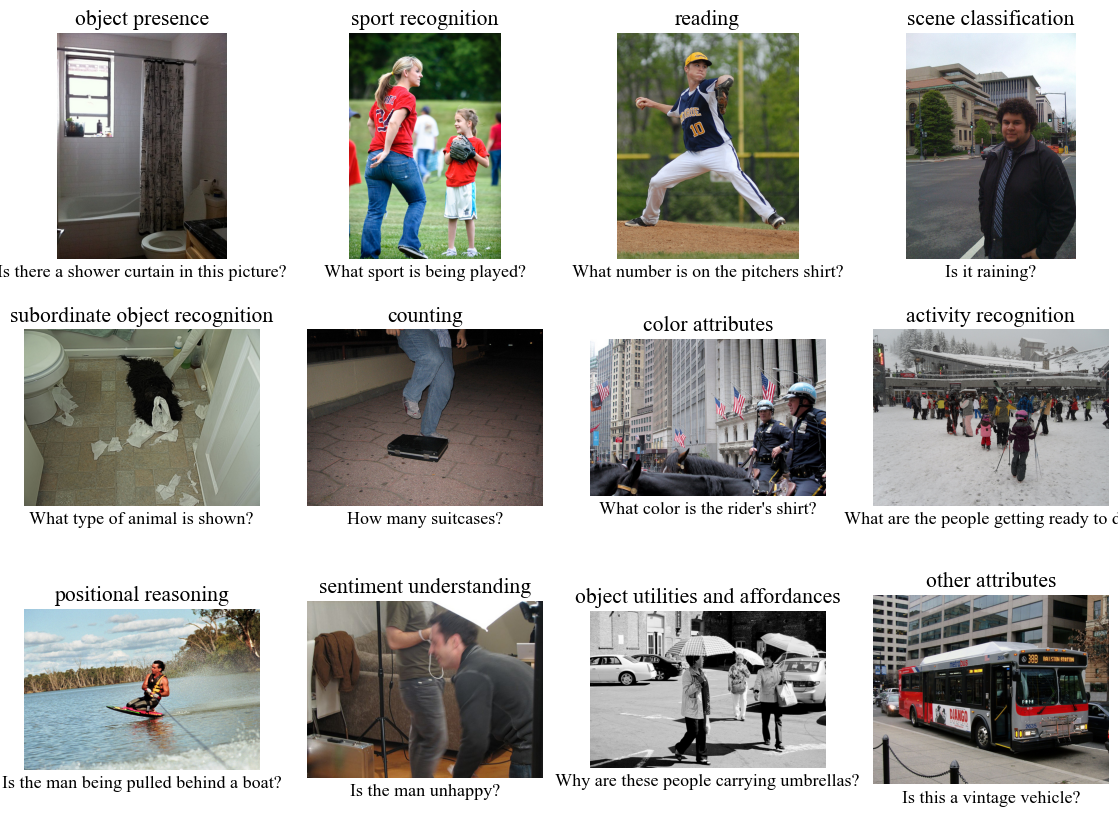

In [50]:
fig, axes = plt.subplots(3, 4, figsize=(14, 10)) #figsize=(10, 3)
flattened_axes = np.array(axes).flatten()

order = [0, 5, 10, 7, 1, 2, 3, 4, 6, 8, 9, 11]
for plot_dx, idx in enumerate(order):
    reasoning_type = list(mapped.keys())[idx]
    if reasoning_type == "absurd":
        continue
    image = loader.load_images([mapped[reasoning_type][0]])[0]
    question = loader.load_questions([mapped[reasoning_type][0]])[0]
    if reasoning_type == "subordinate object recognition":
        question = "What type of animal is shown?"
    flattened_axes[plot_dx].imshow(np.asarray(image))
    flattened_axes[plot_dx].set_title(reasoning_type)
    flattened_axes[plot_dx].set_xlabel(question)
    
for ax in flattened_axes:
    ax.axis("tight")  # gets rid of white border
    ax.axis("image")  # square up the image instead of filling the "figure" space
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
plt.savefig("outputs/plots/reasoning_types.pdf")

### High Resolution Gaze Plots

In [46]:
blip_att, _, _ = loader.load_model_results("blip")
vilt_att, _, _ = loader.load_model_results("vilt")
beit_att, _, _ = loader.load_model_results("beit3")

max_h_dim = max([x.shape[0] for x in vilt_att.values()])
max_w_dim = max([x.shape[1] for x in vilt_att.values()])
resized_vilt_atts = [cv2.resize(x, (max_h_dim, max_w_dim)) for x in vilt_att.values()]

mean_blip_att = np.array(list(blip_att.values())).mean(axis=0)
mean_vilt_att = np.array(resized_vilt_atts).mean(axis=0)
mean_beit_att = np.array(list(beit_att.values())).mean(axis=0)

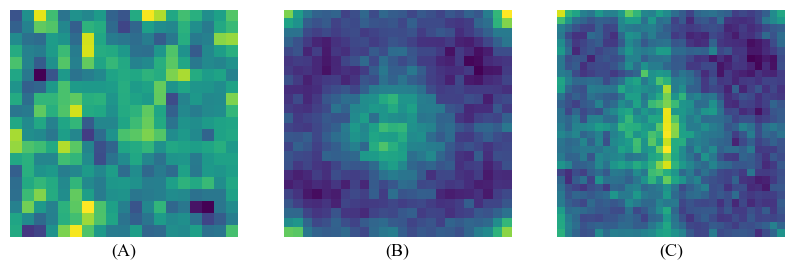

In [84]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3)) #figsize=(10, 3)
(ax1, ax2, ax3) = axes
ax1.imshow(mean_vilt_att)
ax1.set_xlabel("(A)")
ax2.imshow(mean_blip_att)
ax2.set_xlabel("(B)")
ax3.imshow(mean_beit_att)
ax3.set_xlabel("(C)")

for ax in axes:
    ax.axis("tight")  # gets rid of white border
    ax.axis("image")  # square up the image instead of filling the "figure" space
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
plt.savefig("outputs/plots/mean_transformer_heatmaps.pdf")

In [20]:
gauss_heatmaps, low_res_heatmaps = loader.load_computed_heatmaps()
resized_gauss_heatmaps = [cv2.resize(x, (1000, 1000)) for x in gauss_heatmaps]

perf_dfs = loader.load_computed_performance_scores()
accuracy_df, vqav2_df, wu_palmer_df, cosine_df = perf_dfs
grouped_cosine_df = get_mean_performance_reasoning_types(cosine_df)

NameError: name 'heatmaps' is not defined

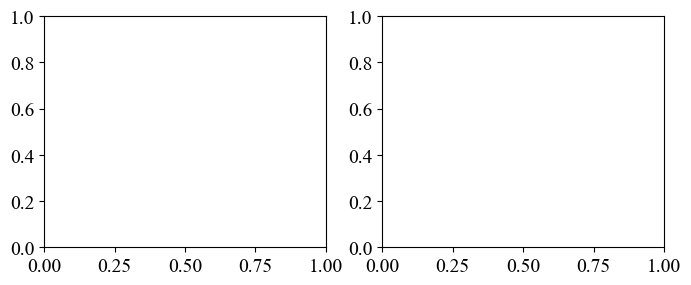

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.imshow(np.array(heatmaps).mean(axis=0))
ax2.imshow(np.array(resized_gauss_heatmaps).mean(axis=0))
ax1.set_xlabel("(A)")
ax2.set_xlabel("(B)")

for ax in [ax1, ax2]:
    ax.axis("tight")  # gets rid of white border
    ax.axis("image")  # square up the image instead of filling the "figure" space
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
plt.savefig("outputs/plots/mean_human_heatmaps.pdf")

In [22]:
# Load annotations
a = loader.load_experiment_questions_for_group(1, only_values=False)
b = loader.load_experiment_questions_for_group(2, only_values=False)
reasoning_type_df = pd.concat([a, b])

res_dict = {res_type: [] for res_type in reasoning_type_df.columns}
general_heatmap_dict = {res_type: [] for res_type in reasoning_type_df.columns}

for q_id in low_res_heatmaps.keys():
    r_type = reasoning_type_df.isin([q_id]).any()[reasoning_type_df.isin([q_id]).any() == True].index[0]
    res_dict[r_type].append(q_id)
    general_heatmap_dict[r_type].append((q_id, low_res_heatmaps[q_id]))
    
mean_heatmap_dict = {}

for res_type, q_ids in res_dict.items():
    
    g_heatmaps = []
    l_heatmaps = []
    
    for q_id in q_ids:
        l_heatmaps.append(low_res_heatmaps[q_id])
        g_heatmaps.append(gauss_heatmaps[q_id])
        
    mean_heatmap_dict[res_type] = np.array(l_heatmaps).mean(axis=0)

0.41791903173473677


<Figure size 640x480 with 0 Axes>

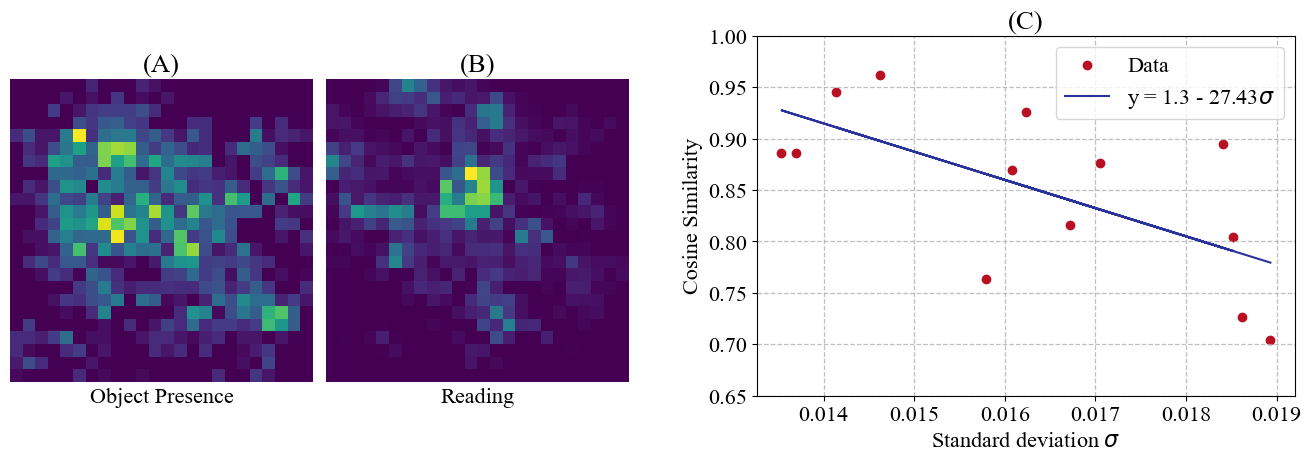

In [181]:
plt.rcParams["font.size"] = 16
plt.tight_layout()
fig = plt.figure(constrained_layout=True, figsize=(13, 4.5))
(subfig_l, subfig_r) = fig.subfigures(nrows=1, ncols=2, wspace=0.07)
ax = subfig_r.subplots(1, 1)

ax.grid(True, linestyle='--', linewidth=0.9, alpha=0.8, zorder=-1)
tick_lst = [x for x in range(len(grouped_cosine_df.index))]
tick_label_lst = grouped_cosine_df.index.values
stds = [mean_heatmap_dict[x].std() for x in grouped_cosine_df.index.values]

from sklearn.linear_model import LinearRegression
# X =  grouped_cosine_df["human"].values.flatten().reshape(-1, 1)
# y = stds
y =  grouped_cosine_df["human"].values.flatten()
X = np.array(stds).reshape(-1, 1)
reg = LinearRegression().fit(X, y)
fit_score = reg.score(X, y)
slope = reg.coef_
intercept = reg.intercept_
print(fit_score)

ax.scatter(stds, grouped_cosine_df["human"], color=COLORS["RED"], label="Data")
ax.plot(X, intercept + slope * X, color=COLORS["BLUE"], label=f"y = {round(intercept, 2)} - {round(slope[0], 2) * -1}$\sigma$")
ax.set_ylim((0.65, 1))
# ax.set_xlim((0.013, 0.019))
# ax.set_xticks(tick_lst, labels=tick_label_lst, rotation=50, ha="right")
ax.set_ylabel("Cosine Similarity")
ax.set_xlabel("Standard deviation $\sigma$")
ax.set_title("(C)")
ax.legend()

(ax_u, ax_l) = subfig_l.subplots(1, 2)
ax_u.imshow(mean_heatmap_dict["object presence"])
ax_l.imshow(mean_heatmap_dict["reading"])
ax_u.set_xlabel("Object Presence")
ax_l.set_xlabel("Reading")
ax_u.set_title("(A)")
ax_l.set_title("(B)")

for ax in (ax_u, ax_l):
    ax.axis("tight")  # gets rid of white border
    ax.axis("image")  # square up the image instead of filling the "figure" space
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.savefig("outputs/plots/human_heatmap_variances.pdf", bbox_inches="tight")
plt.rcParams["font.size"] = 14

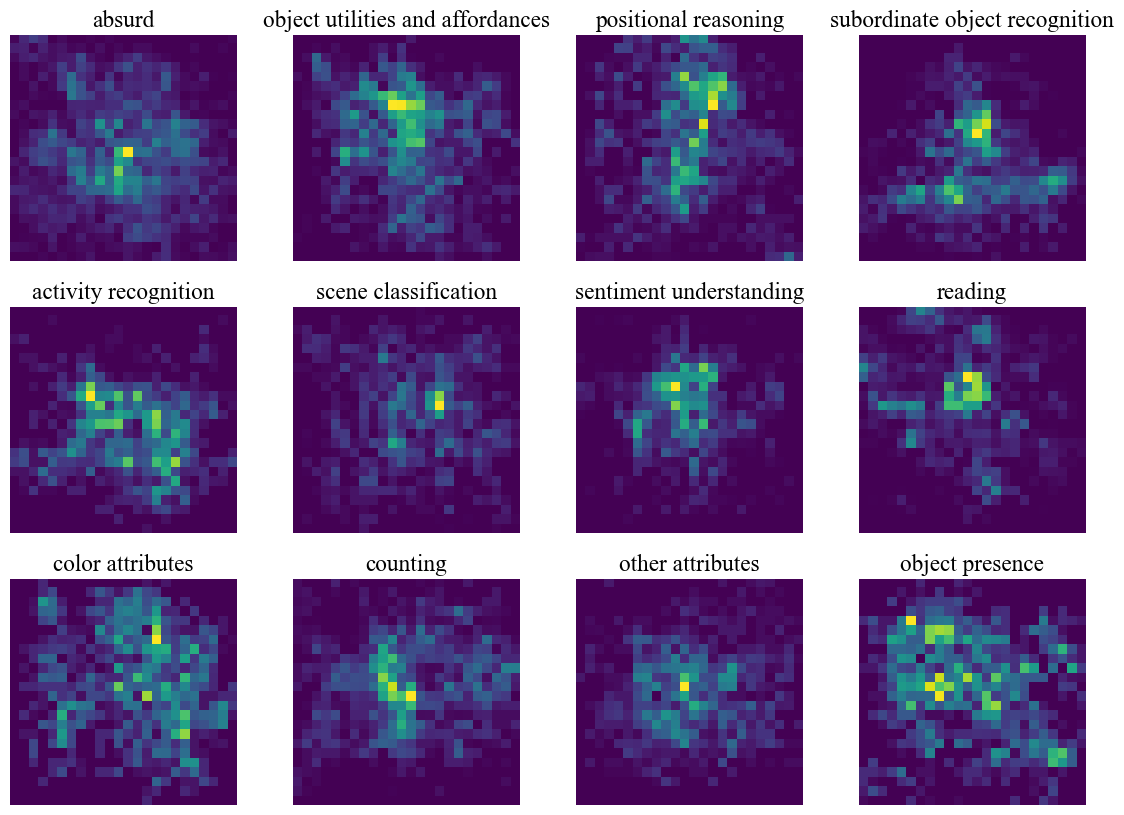

In [90]:
fig, axes = plt.subplots(3, 4, figsize=(14, 10)) #figsize=(10, 3)
flattened_axes = np.array(axes).flatten()
order = grouped_cosine_df.index.values

for res_type, ax in zip(order, flattened_axes):
    ax.imshow(mean_heatmap_dict[res_type])
    ax.set_title(res_type)
    
for ax in flattened_axes:
    ax.axis("tight")  # gets rid of white border
    ax.axis("image")  # square up the image instead of filling the "figure" space
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

In [27]:
mean_heatmaps = []

for vp in valid_fixations["vp_code"].value_counts().index:
    
    vp_slice = valid_fixations[valid_fixations["vp_code"] == vp]
    vp_hmaps = []
    
    for q_id in vp_slice["question_id"].value_counts().index:
        
        q_slice = vp_slice[vp_slice["question_id"] == q_id]
        
        vp_hmaps.append(
            hmaps.compute_low_res_human_heatmap(
                valid_fixations, logger_df, q_id, att_map_shape=(24, 24), reduction=np.mean
            )
        )
    
    mean_heatmaps.append(np.array(vp_hmaps).mean(axis=0))
        

AN01RG
OL89EN
AN00CH
ZE99RG
JU96EN
NI00LN
ST95HE
IR99RN
CL98LN
MA99RG
KR99RN
ED01IM
PE95DT
MU97NG
PI01CH
OL98RN
JA01EN
CE93RT
GU03EN
CL02DT


In [39]:
from itertools import permutations

perm_set = permutations(mean_heatmaps,2)
corr_scores = []
for a in perm_set:
    h1, h2 = a
    corr_scores.append(rank_correlation(h1, h2))
print(np.mean(corr_scores))

0.9249000806096194


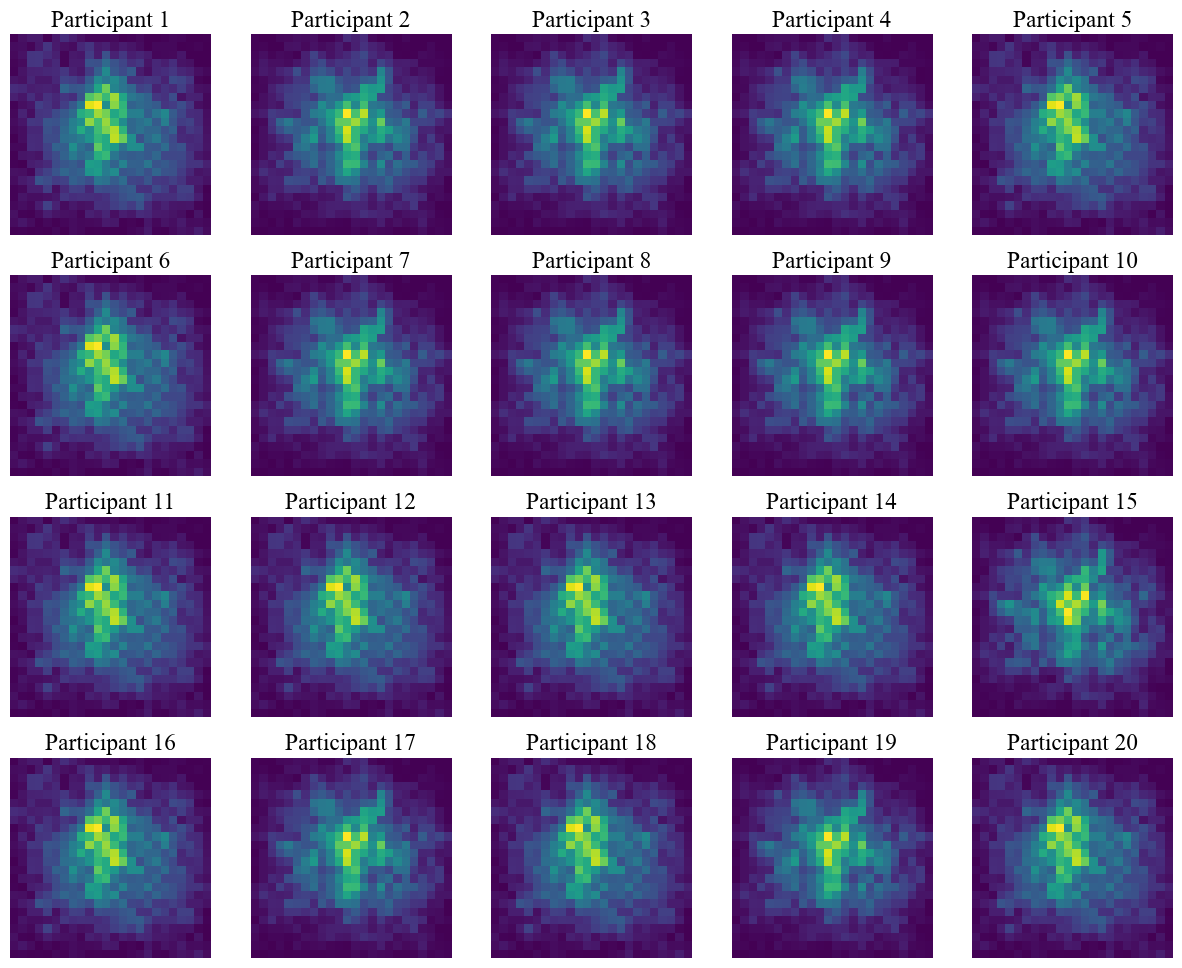

In [41]:
fig, axes = plt.subplots(4, 5, figsize=(15,12))
flattened_axes = np.array(axes).flatten()

i = 1
for hmap, ax in zip(mean_heatmaps, flattened_axes):
    ax.imshow(hmap)
    ax.set_title("Participant "+ str(i))
    i += 1
    
for ax in flattened_axes:
    ax.axis("tight")  # gets rid of white border
    ax.axis("image")  # square up the image instead of filling the "figure" space
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
plt.savefig("outputs/plots/participant_heatmaps.pdf", bbox_inches="tight")

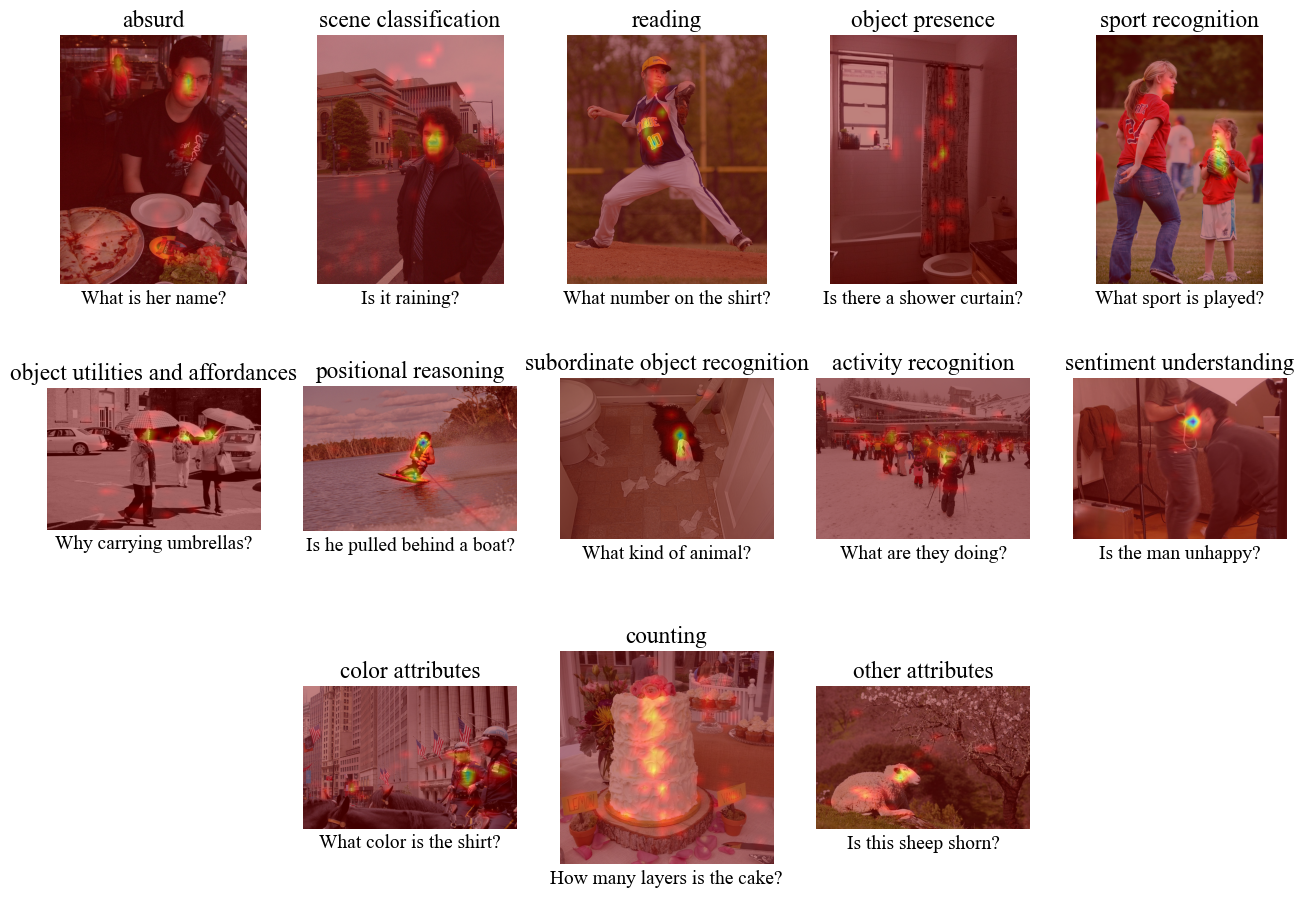

In [47]:
fig, axes = plt.subplots(3, 5, figsize=(16, 11)) #figsize=(10, 3)
flattened_axes = np.array(axes).flatten()
order = grouped_cosine_df.index.values
order = order[[0, 5, 7, 11, 12, 1, 2, 3, 4, 6, 8, 9, 10]]
HEATMAP_QUESTIONS_FIXED = ["What is her name?", "Is it raining?", "What number on the shirt?", "Is there a shower curtain?", "What sport is played?",
                           "Why carrying umbrellas?", "Is he pulled behind a boat?", "What kind of animal?", "What are they doing?", "Is the man unhappy?",
                           "What color is the shirt?", "How many layers is the cake?", "Is this sheep shorn?"]
for idx, (res_type, ax) in enumerate(zip(order, flattened_axes)):
    q_id = reasoning_type_df[res_type].values[0]
    img = loader.load_images([q_id])[0]
    heatmap = low_res_heatmaps[q_id]
    
    if idx >= 10:
        ax = flattened_axes[idx + 1]
    ax.imshow(fuze_image_and_array(img, resize_array_to_img(img, heatmap * 1.2), map_strength=1))
    ax.set_title(res_type)
    ax.set_xlabel(HEATMAP_QUESTIONS_FIXED[idx])
    
for ax in flattened_axes:
    ax.axis("tight")  # gets rid of white border
    ax.axis("image")  # square up the image instead of filling the "figure" space
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
plt.savefig("outputs/plots/human_heatmaps_reasoning_categories_examples.pdf", bbox_inches="tight")

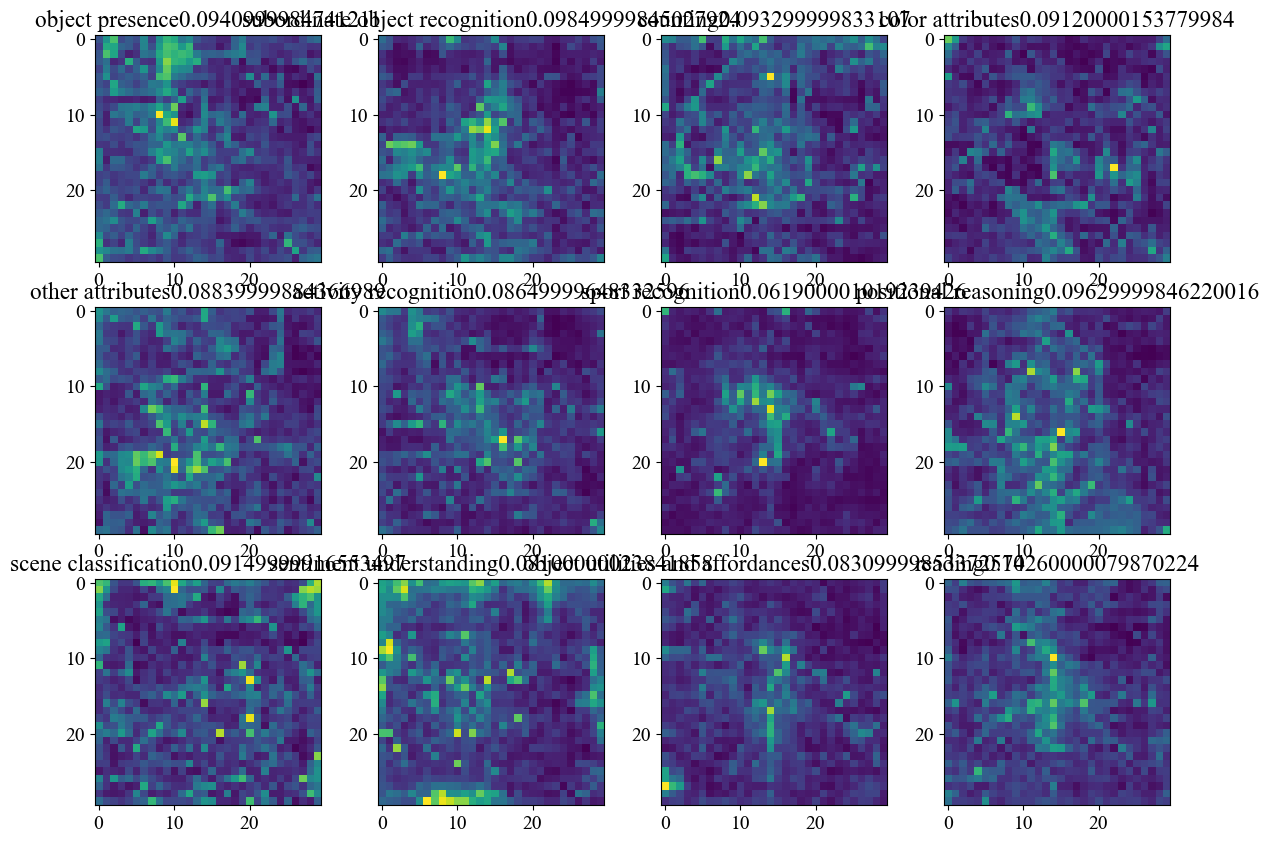

In [24]:
vilt_att, _, _ = loader.load_model_results("vilt")
blip_att, _, _ = loader.load_model_results("blip")
beit_att, _, _ = loader.load_model_results("beit3")

fig, axes = plt.subplots(3, 4, figsize=(14, 10)) #figsize=(10, 3)
flattened_axes = np.array(axes).flatten()

vilt_mean_maps = []
blip_mean_maps = []
beit_mean_maps = []

for ax, (r_type, qids) in zip(flattened_axes, res_dict.items()):
    
    vilt_maps = []
    blip_maps = []
    beit_maps = []
    
    for q_id in qids:
        
        vilt_maps.append(vilt_att[str(q_id)])
        blip_maps.append(blip_att[str(q_id)])
        beit_maps.append(beit_att[str(q_id)])
        
    vilt_mean_maps.append(np.array([cv2.resize(x, (19, 19)) for x in vilt_maps]).mean(axis=0))
    blip_mean_maps.append(np.array(blip_maps).mean(axis=0))
    beit_mean_maps.append(np.array(beit_maps).mean(axis=0))
    
    ax.imshow(np.array(beit_maps).mean(axis=0))
    ax.set_title(r_type + f"{round(np.array(beit_maps).std(), 4)}")
    

In [11]:
blip_stds = [x.std() for x in blip_mean_maps]
blip_stds = {k:v for k, v in zip(res_dict.keys(), blip_stds)}

In [18]:
print(np.array(vilt_mean_maps).std())
print(np.array(blip_mean_maps).std())
print(np.array(beit_mean_maps).std())

0.03535921
0.04012332
0.028783366


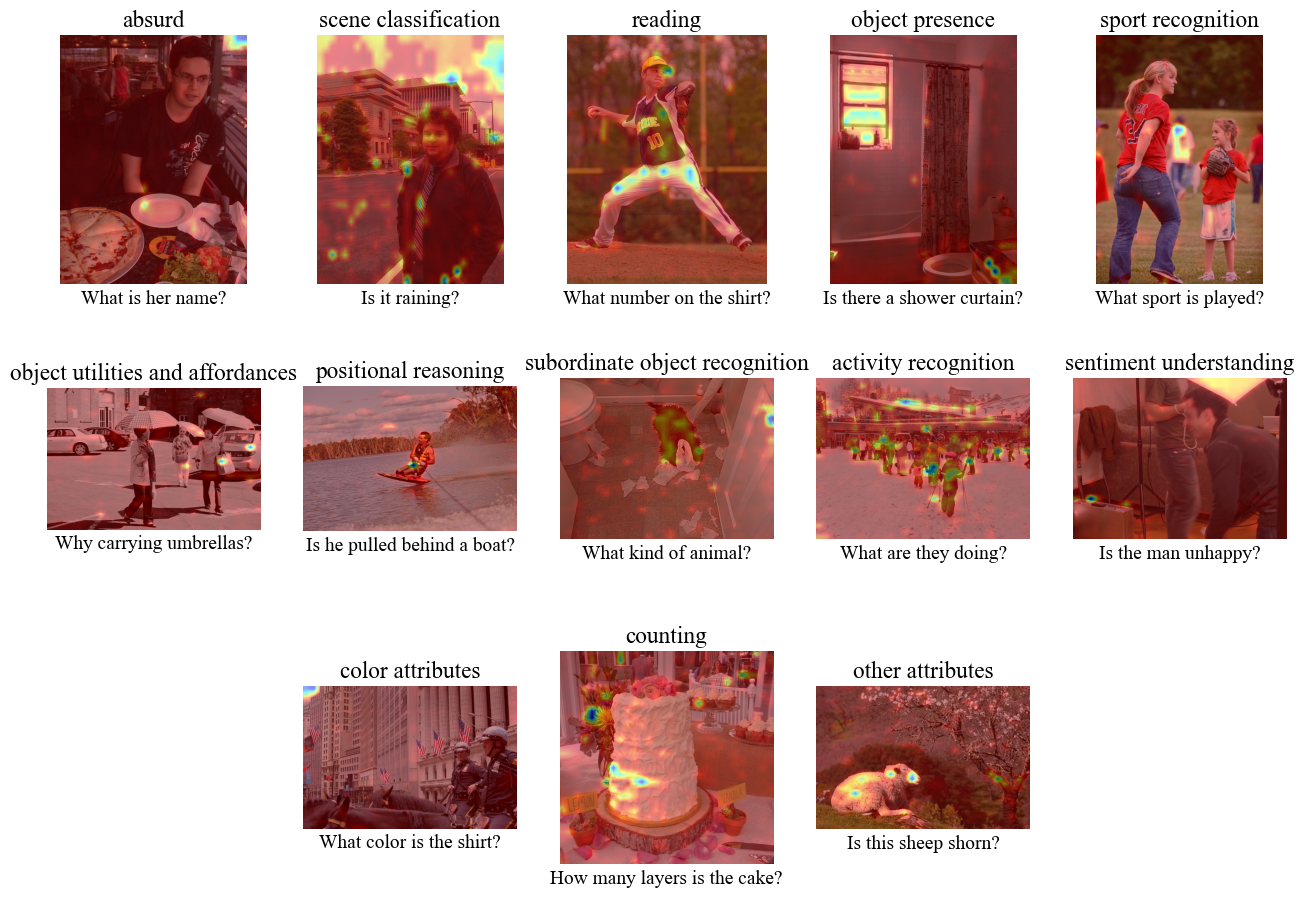

In [53]:
fig, axes = plt.subplots(3, 5, figsize=(16, 11)) #figsize=(10, 3)
flattened_axes = np.array(axes).flatten()
order = grouped_cosine_df.index.values
order = order[[0, 5, 7, 11, 12, 1, 2, 3, 4, 6, 8, 9, 10]]

for idx, (res_type, ax) in enumerate(zip(order, flattened_axes)):
    q_id = reasoning_type_df[res_type].values[0]
    img = loader.load_images_no_harddrive([q_id])[0]
    heatmap = beit_att[str(q_id)]
    
    if idx >= 10:
        ax = flattened_axes[idx + 1]
    ax.imshow(fuze_image_and_array(img, resize_array_to_img(img, heatmap), map_strength=0.8))
    ax.set_title(res_type)
    ax.set_xlabel(HEATMAP_QUESTIONS_FIXED[idx])
    
for ax in flattened_axes:
    ax.axis("tight")  # gets rid of white border
    ax.axis("image")  # square up the image instead of filling the "figure" space
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
plt.savefig("outputs/plots/beit_heatmaps_reasoning_categories_examples.pdf", bbox_inches="tight")

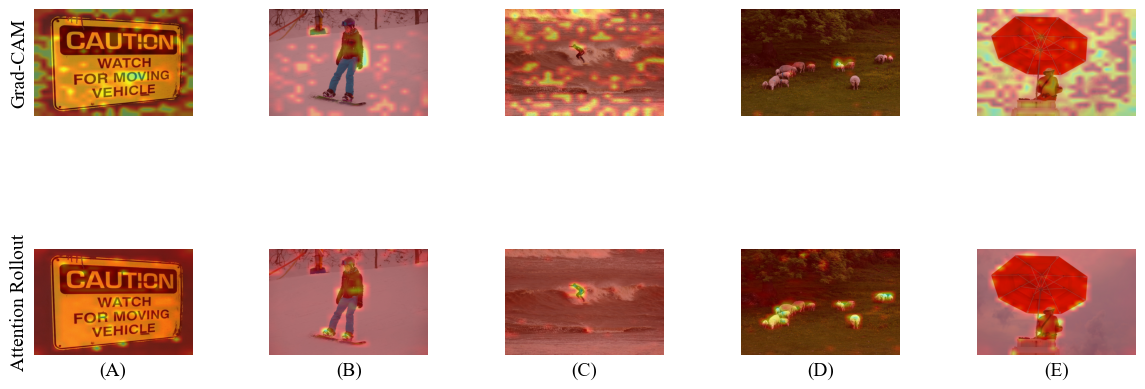

In [127]:
fig, axes = plt.subplots(2, 5, figsize=(12,5))
plt.tight_layout()
qids = list(att_rollout_dict.keys())
order = [2, 10, 12, 26, 43]
for idx, orde in enumerate(order):
    q_id = qids[orde]
    image = loader.load_images([q_id])[0]
    image = cv2.resize(np.asarray(image), (1280, 860))
    ax2, ax3 = axes[:, idx]
    if idx == 0:
        ax2.set_ylabel("Grad-CAM", size=14)
        ax3.set_ylabel("Attention Rollout", size=14)
    ax2.imshow(fuze_image_and_array(image, cv2.resize(grad_cam_dict[q_id] * 0.6, (1280, 860)), map_strength=0.7))
    ax3.imshow(fuze_image_and_array(image, cv2.resize(att_rollout_dict[q_id] * 0.6, (1280, 860)), map_strength=0.9))
    ax3.set_xlabel("(" + ["A", "B", "C", "D", "E"][idx] + ")")
    
for ax in np.array(axes).flatten():
    ax.axis("tight")  # gets rid of white border
    ax.axis("image")  # square up the image instead of filling the "figure" space
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    

plt.savefig("outputs/plots/gradcam_rollout_examples.pdf")

In [47]:
low_heatmap_scores = {"corr": [], "kldiv": [], "aucs": [], "nsss": []}

for res_type in grouped_cosine_df["blip"].sort_values().index:
    items = general_heatmap_dict[res_type]
    corrs, kl_divs, aucs, nsss = [], [], [], []

    for q_id, heatmap in items:
        blip_heatmap = blip_att[str(q_id)]
        
        corrs.append(rank_correlation(blip_heatmap, heatmap))
        kl_divs.append(kl_divergence(blip_heatmap, heatmap))
        aucs.append(auc_judd(blip_heatmap, heatmap))
        nsss.append(nss(blip_heatmap, heatmap))
    
    low_heatmap_scores["corr"].append(np.mean(corrs))
    low_heatmap_scores["kldiv"].append(np.mean(kl_divs))
    low_heatmap_scores["aucs"].append(np.mean(aucs))
    low_heatmap_scores["nsss"].append(np.mean(nsss))


In [49]:
reasoning_similarity_df = pd.DataFrame.from_dict(low_heatmap_scores)
reasoning_similarity_df.index = grouped_cosine_df["blip"].sort_values().index
reasoning_similarity_df.mean()

corr     0.141691
kldiv    3.403079
aucs     0.654033
nsss     0.580169
dtype: float64

In [4]:
perf_dfs = loader.load_computed_performance_scores()
accuracy_df, vqav2_df, wu_palmer_df, cosine_df = perf_dfs

human_scores = []
vilt_scores = []
blip_scores = []
beit_scores = []

for df in perf_dfs:
    human_scores.append(np.nanmean(df[[f"Participant_{x + 1}" for x in range(10)]].values))
    vilt_scores.append(np.nanmean(df["vilt"].values))
    blip_scores.append(np.nanmean(df["blip"].values))
    beit_scores.append(np.nanmean(df["beit"].values))

preprocessed_df = pd.DataFrame([human_scores, vilt_scores, blip_scores, beit_scores])
preprocessed_df = pd.DataFrame([human_scores, vilt_scores, blip_scores, beit_scores]).T.round(decimals=4)
preprocessed_df.columns = ["Human", "ViLT", "BLIP", "BEiT"]
preprocessed_df.index = ["Accuracy", "VQAv2-Accuracy", "Wu-Palmer", "Cosine"]

grouped_cosine_df = get_mean_performance_reasoning_types(cosine_df)

display(preprocessed_df)

Human    ViLT    BLIP    BEiT
Accuracy        0.7387  0.7115  0.7372  0.7949
VQAv2-Accuracy  0.8290  0.7543  0.8184  0.8526
Wu-Palmer       0.7953  0.7398  0.7659  0.7789
Cosine          0.8509  0.7706  0.8147  0.8170

In [14]:
c_df = cosine_df.copy()
c_df["human"] = cosine_df[[f"Participant_{x + 1}" for x in range(10)]].mean(axis=1)
c_df.groupby("reasoning_type").std()

Participant_1  Participant_2  Participant_3  \
reasoning_type                                                                  
absurd                                 0.452267       0.389249       0.522233   
activity recognition                   0.255608       0.204089       0.168921   
color attributes                       0.085303       0.079286       0.191720   
counting                               0.218121       0.083099       0.241665   
object presence                        0.077291       0.077291       0.077291   
object utilities and affordances       0.239677       0.230780       0.171257   
other attributes                       0.163138       0.165246       0.077060   
positional reasoning                   0.253607       0.225041       0.210827   
reading                                0.195638       0.179805       0.256439   
scene classification                   0.149684       0.102521       0.106178   
sentiment understanding                0.102039       0.200407       0.102233   
sport recognition                      0.038788       0.066398       0.051564   
subordinate object recognition         0.222175       0.241035       0.197382   

                                  Participant_4  Participant_5  Participant_6  \
reasoning_type                                                                  
absurd                                 0.492366       0.492366       0.514929   
activity recognition                   0.185637       0.326579       0.223120   
color attributes                       0.145960       0.248937       0.075000   
counting                               0.169726       0.260084       0.231906   
object presence                        0.196761       0.102092       0.223685   
object utilities and affordances       0.195824       0.225332       0.245523   
other attributes                       0.030206       0.077060       0.264805   
positional reasoning                   0.224565       0.244409       0.258037   
reading                                0.222750       0.283462       0.190101   
scene classification                   0.205372       0.102697       0.232736   
sentiment understanding                0.078013       0.214131       0.180390   
sport recognition                      0.070082       0.063736       0.038788   
subordinate object recognition         0.235400       0.319502       0.188245   

                                  Participant_7  Participant_8  Participant_9  \
reasoning_type                                                                  
absurd                                 0.288675       0.492366       0.452267   
activity recognition                   0.317727       0.249694       0.323191   
color attributes                       0.113210       0.179171       0.082192   
counting                               0.236980       0.168436       0.241779   
object presence                        0.077291       0.076861       0.168272   
object utilities and affordances       0.203495       0.241148       0.208817   
other attributes                       0.149100       0.187832       0.077060   
positional reasoning                   0.238190       0.275562       0.245707   
reading                                0.161932       0.236686       0.190004   
scene classification                   0.229348       0.187659       0.169908   
sentiment understanding                0.236309       0.168065       0.170916   
sport recognition                      0.051564       0.068054       0.038788   
subordinate object recognition         0.275697       0.235360       0.186808   

                                  Participant_10      vilt      blip  \
reasoning_type                                                         
absurd                                  0.467099  0.389249  0.452267   
activity recognition                    0.180927  0.217967  0.196628   
color attributes                        0.142825  0.125467  0.132911   
counting                  

In [3]:
perf_nopreproc_dfs = loader.load_computed_performance_scores_no_preproc()
accuracy_df_nopreproc, vqav2_df_nopreproc, wu_palmer_df_nopreproc, cosine_df_nopreproc = perf_nopreproc_dfs

human_scores_nopreproc = []
vilt_scores_nopreproc = []
blip_scores_nopreproc = []
beit_scores_nopreproc = []

for df in perf_nopreproc_dfs:
    human_scores_nopreproc.append(np.nanmean(df[[f"Participant_{x + 1}" for x in range(10)]].values))
    vilt_scores_nopreproc.append(np.nanmean(df["vilt"].values))
    blip_scores_nopreproc.append(np.nanmean(df["blip"].values))
    beit_scores_nopreproc.append(np.nanmean(df["beit"].values))

preprocessed_df_nopreproc = pd.DataFrame([human_scores_nopreproc, vilt_scores_nopreproc, blip_scores_nopreproc, beit_scores_nopreproc])
preprocessed_df_nopreproc = pd.DataFrame([human_scores_nopreproc, vilt_scores_nopreproc, blip_scores_nopreproc, beit_scores_nopreproc]).T.round(decimals=4)
preprocessed_df_nopreproc.columns = ["Human", "ViLT", "BLIP", "BEiT"]
preprocessed_df_nopreproc.index = ["Accuracy", "VQAv2-Accuracy", "Wu-Palmer", "Cosine"]
preprocessed_df_nopreproc

Human    ViLT    BLIP    BEiT
Accuracy        0.5674  0.7051  0.7244  0.8077
VQAv2-Accuracy  0.5871  0.7479  0.7906  0.8397
Wu-Palmer       0.5772  0.7051  0.7092  0.7369
Cosine          0.7726  0.7742  0.8149  0.8169

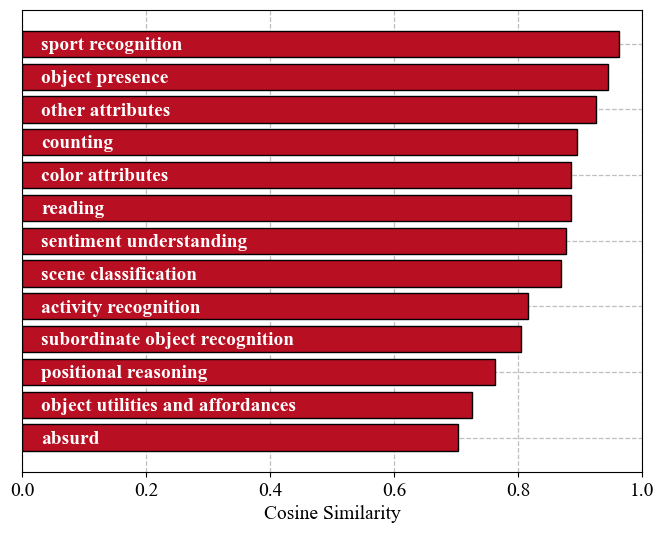

In [164]:
fig, ax = plt.subplots(figsize=(8,6))
plt.grid(True, linestyle='--', linewidth=0.9, alpha=0.8, zorder=-1)
ax.barh(range(len(grouped_cosine_df.index)), grouped_cosine_df["human"], zorder=2, edgecolor="black", color=COLORS["RED"])
ax.set_xlabel("Cosine Similarity")
ax.set_xlim((0,1))
ax.tick_params(axis="y", direction="in")
ax.set_yticklabels([])

for idx, r in enumerate(grouped_cosine_df.index):
    ax.text(0.03, idx - 0.18, r, ha="left", color="white", weight="bold")

plt.savefig("outputs/plots/human_performance_reasoning_types.pdf")

In [51]:
# F(12) =s, 9.167, 14.55

populations = []
cosine_df["human"] = cosine_df.apply(lambda sl: np.nanmean(sl[[f"Participant_{x + 1}" for x in range(10)]].values), axis=1)

for r_type in cosine_df["reasoning_type"].value_counts().index.values:
    populations.append(cosine_df[cosine_df["reasoning_type"] == r_type]["beit"].values)
    
scipy.stats.f_oneway(*tuple(populations))

F_onewayResult(statistic=8.121226229426346, pvalue=1.6901957968839128e-11)

In [48]:
populations = []
cosine_df["human"] = cosine_df.apply(lambda sl: np.nanmean(sl[[f"Participant_{x + 1}" for x in range(10)]].values), axis=1)

for r_type in cosine_df["reasoning_type"].value_counts().index.values:
    populations.append(cosine_df[cosine_df["reasoning_type"] == r_type]["human"].values)
    
scipy.stats.f_oneway(*tuple(populations))

F_onewayResult(statistic=4.102764410877038, pvalue=1.6910916786287886e-05)

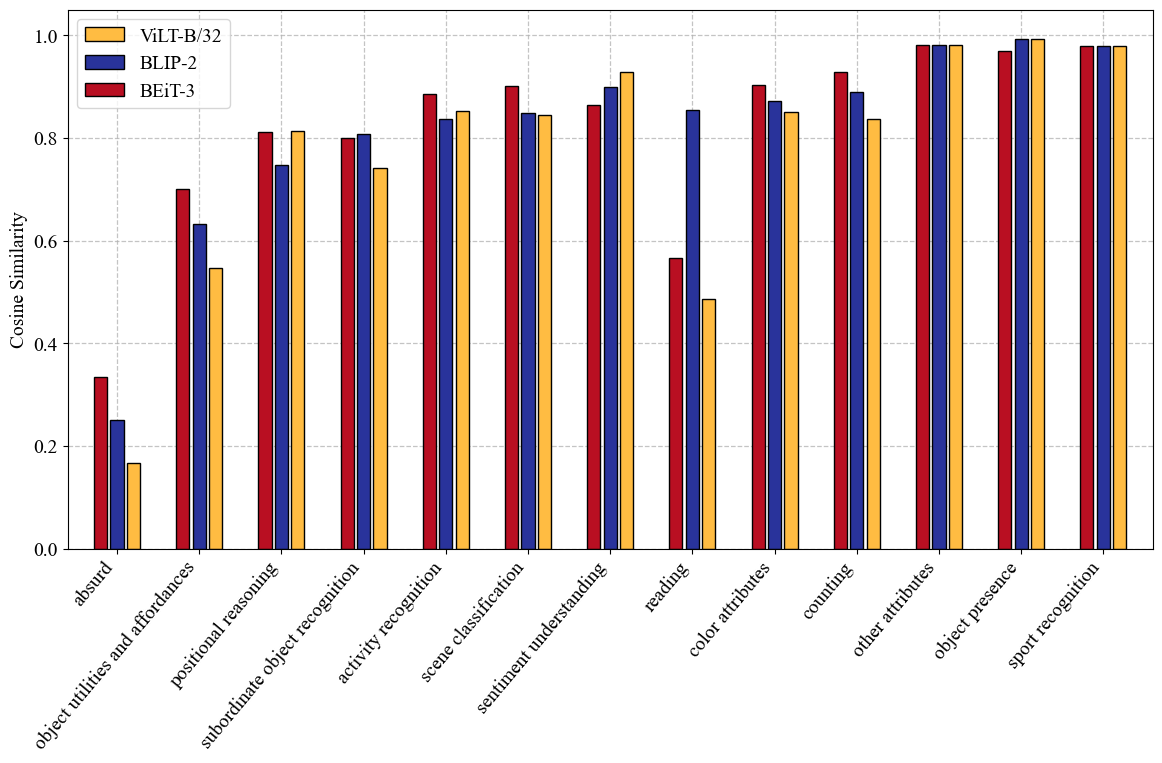

In [127]:
fig, axes = plt.subplots(figsize=(14,7))

plt.grid(True, linestyle='--', linewidth=0.9, alpha=0.75, zorder=-1)
plt.ylim((0, 1.05))
plt.ylabel("Cosine Similarity")
tick_lst = [5 * x for x in range(len(grouped_cosine_df.index))]
tick_label_lst = grouped_cosine_df.index.values
plt.xticks(tick_lst, labels=tick_label_lst, rotation=50, ha="right")
plt.xlim((-3, 63))

cols = [COLORS["ORANGE"], COLORS["BLUE"], COLORS["RED"]]
for model, model_str, offset, col in zip(["vilt", "blip", "beit"], ["ViLT-B/32", "BLIP-2", "BEiT-3"], [1, 0, -1], cols):
    plt.bar(np.array(list(range(len(grouped_cosine_df.index)))) * 5 + offset, grouped_cosine_df[model], zorder=2, edgecolor="black", label=model_str, color=col)

plt.legend()
plt.savefig("outputs/plots/transformer_performance_reasoning_types.pdf", bbox_inches='tight')

In [6]:
# List of all participants
participant_col_list = [f"Participant_{x + 1}" for x in range(10)]

perf_df = cosine_df.copy()
perf_df["human"] = perf_df[participant_col_list].mean(axis=1)
perf_df = perf_df[["human", "question_id"]]

In [24]:
X_new = logger_df[["time_on_image", "question_id"]].groupby("question_id").mean().loc[perf_df["question_id"].values].values
Y_new = perf_df["human"].values

reg_new = LinearRegression().fit(X_new, Y_new)
print(reg_new.score(X_new, Y_new))
slope_new = reg_new.coef_
intercept_new = reg_new.intercept_

0.43396993552625496


In [7]:
logger_df_reasoning_type = append_reasoning_type_to_df(logger_df)

grouped_time = logger_df_reasoning_type[["time_on_image", "reasoning_type"]].groupby("reasoning_type").mean()
grouped_time = grouped_time.sort_values(by=["time_on_image"])
grouped_time = grouped_time.loc[grouped_cosine_df.index.values]

In [25]:
import statsmodels.api as sm
mod = sm.OLS(Y_new,X_new)
fii = mod.fit()
print(fii.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.606
Model:                            OLS   Adj. R-squared (uncentered):              0.604
Method:                 Least Squares   F-statistic:                              238.8
Date:                Wed, 02 Aug 2023   Prob (F-statistic):                    3.42e-33
Time:                        18:52:12   Log-Likelihood:                         -125.96
No. Observations:                 156   AIC:                                      253.9
Df Residuals:                     155   BIC:                                      257.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [12]:
from sklearn.linear_model import LinearRegression
X = grouped_time.values.flatten().reshape(-1, 1)
y = grouped_cosine_df["human"].values.flatten()
reg = LinearRegression().fit(X, y)
fit_score = reg.score(X, y)
slope = reg.coef_
intercept = reg.intercept_
print(fit_score)

0.5900966938943023


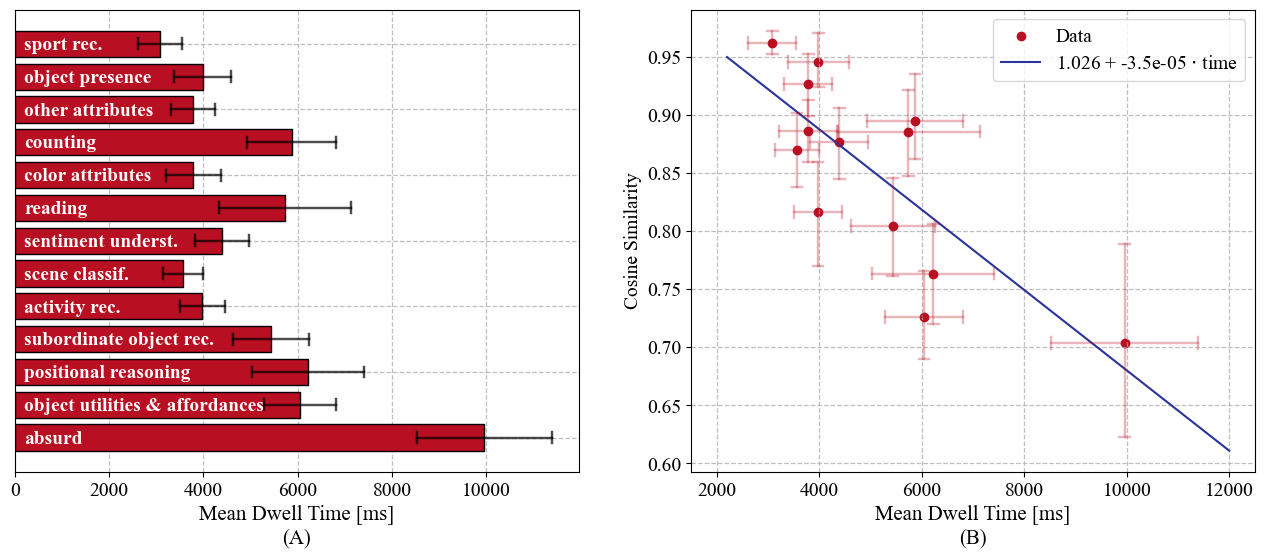

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

ax1.grid(True, linestyle='--', linewidth=0.9, alpha=0.8, zorder=-1)
ax1.barh(range(len(grouped_time.index)), grouped_time.values.flatten(), zorder=2, edgecolor="black", color=COLORS["RED"])
ax1.set_xlabel("Mean Dwell Time [ms]\n(A)", size=15)
ax1.tick_params(axis="y", direction="in")
ax1.set_yticklabels([])
horizontal_line_width = 0.33

for idx, r in enumerate(grouped_cosine_df.index):
    
    d_here = logger_df_reasoning_type[logger_df_reasoning_type["reasoning_type"] == r]["time_on_image"].values.flatten()

    if "sentiment" in r:
        r = "sentiment underst."
        
    if "scene" in r:
        r = "scene classif."
        
    if "sport" in r:
        r = "sport rec."
        
    if "activity" in r:
        r = "activity rec."
        
    if "subordinate" in r:
        r = "subordinate object rec."
    
    if "utilities" in r:
        r = "object utilities & affordances"
        
    ax1.text(200, idx - 0.18, r, ha="left", color="white", weight="bold", zorder=10)
    
    _, conf_lower, conf_upper = mean_confidence_interval(d_here)

    left = idx - horizontal_line_width / 2
    top = conf_upper
    right = idx + horizontal_line_width / 2
    bottom = conf_lower

    ax1.plot([top, bottom], [idx, idx], color="black", alpha=0.7, zorder=4, linewidth=1.75)
    ax1.plot([top, top], [left, right], color="black", alpha=0.7, zorder=4, linewidth=1.75)
    ax1.plot([bottom, bottom], [left, right], color="black", alpha=0.7, zorder=4, linewidth=1.75)

    
for idxx, reasoning_t in enumerate(grouped_cosine_df.index):
    datata = cosine_df[cosine_df["reasoning_type"] == reasoning_t][relevant_cols].values.flatten()
    prev_idx = idxx
    nanmean = [x for x in datata if not np.isnan(x)]
    _, conf_lower, conf_upper = mean_confidence_interval(nanmean)

    idxx = grouped_time.values[idxx]
    left = idxx - 210 / 2
    top = conf_upper
    right = idxx + 210 / 2
    bottom = conf_lower
    
    ax2.plot([idxx, idxx], [top, bottom], color=COLORS["RED"], alpha=0.3, zorder=4, linewidth=1.75)
    ax2.plot([left, right], [top, top], color=COLORS["RED"], alpha=0.3, zorder=4, linewidth=1.75)
    ax2.plot([left, right], [bottom, bottom], color=COLORS["RED"], alpha=0.3, zorder=4, linewidth=1.75)
    
    d_here = logger_df_reasoning_type[logger_df_reasoning_type["reasoning_type"] == reasoning_t]["time_on_image"].values.flatten()

    _, conf_lower, conf_upper = mean_confidence_interval(d_here)
    idxx = grouped_cosine_df["human"].values.flatten()[prev_idx]
    left = idxx - 0.01 / 2
    top = conf_upper
    right = idxx + 0.01 / 2
    bottom = conf_lower

    ax2.plot([top, bottom], [idxx, idxx], color=COLORS["RED"], alpha=0.3, zorder=4, linewidth=1.75)
    ax2.plot([top, top], [left, right], color=COLORS["RED"], alpha=0.3, zorder=4, linewidth=1.75)
    ax2.plot([bottom, bottom], [left, right], color=COLORS["RED"], alpha=0.3, zorder=4, linewidth=1.75)
    
ax2.grid(True, linestyle='--', linewidth=0.9, alpha=0.8, zorder=-1)
ax2.set_xlabel("Mean Dwell Time [ms]\n(B)", size=15)
ax2.set_ylabel("Cosine Similarity")
ax2.scatter(grouped_time.values.flatten(), grouped_cosine_df["human"].values.flatten(), color=COLORS["RED"], label="Data")
vals_to_plot = [2200, 4000, 6000, 8000, 12000]# grouped_time.values.flatten()
ax2.plot(vals_to_plot, intercept + slope * vals_to_plot, color=COLORS["BLUE"], label=f"{round(intercept, 3)} + {round(slope[0], 6)} $\cdot$ time")
ax2.legend()
ax2.set_xlim((1500, 12500))
plt.savefig("outputs/plots/human_performance_times.pdf", bbox_inches='tight')

In [47]:
a = logger_df_reasoning_type[logger_df_reasoning_type["reasoning_type"] == "absurd"]["time_on_image"].values.flatten()
cols = logger_df_reasoning_type["reasoning_type"].value_counts().index.values.tolist()
cols.pop(cols.index("absurd"))
b = logger_df_reasoning_type[logger_df_reasoning_type["reasoning_type"].isin(cols)]["time_on_image"].values.flatten()

scipy.stats.ttest_ind(a, b)

Ttest_indResult(statistic=11.625742245096923, pvalue=5.197735324713389e-30)

In [14]:
perf_df = cosine_df.copy()
participant_col_list = [f"Participant_{x + 1}" for x in range(10)]
perf_df["human"] = perf_df[participant_col_list].mean(axis=1)
perf_df = perf_df.drop(columns=participant_col_list)

In [55]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

def fct(x, a, b):
    return a + b * np.log(x)

def fct_root(x, a, b):
    return a *  np.sqrt(x + b)

C:\Users\bock-\AppData\Local\Temp\ipykernel_1240\43663216.py:8: RuntimeWarning: invalid value encountered in sqrt
  return a *  np.sqrt(x + b)


0.38185174141271194


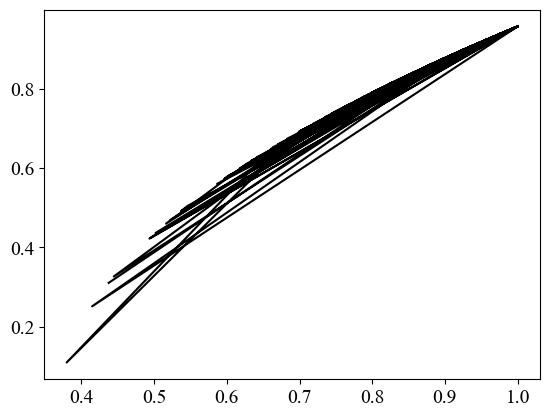

In [75]:
y = perf_df["beit"].values
vals = perf_df["human"].values
est_params, est_cov = curve_fit(fct_root, vals, y)
a, b =  est_params

predicted = [fct_root(x, a, b) for x in vals]

plt.plot(vals, predicted, zorder=2, color="black")
print(r2_score(y, predicted))

C:\Users\bock-\AppData\Local\Temp\ipykernel_1240\43663216.py:8: RuntimeWarning: invalid value encountered in sqrt
  return a *  np.sqrt(x + b)
C:\Users\bock-\AppData\Local\Temp\ipykernel_1240\43663216.py:8: RuntimeWarning: invalid value encountered in sqrt
  return a *  np.sqrt(x + b)
C:\Users\bock-\AppData\Local\Temp\ipykernel_1240\43663216.py:8: RuntimeWarning: invalid value encountered in sqrt
  return a *  np.sqrt(x + b)


1.8238001691038614 -0.662745648035334
1.8437691684136197 -0.6468210799482951
1.6350319345703888 -0.5944133532655297


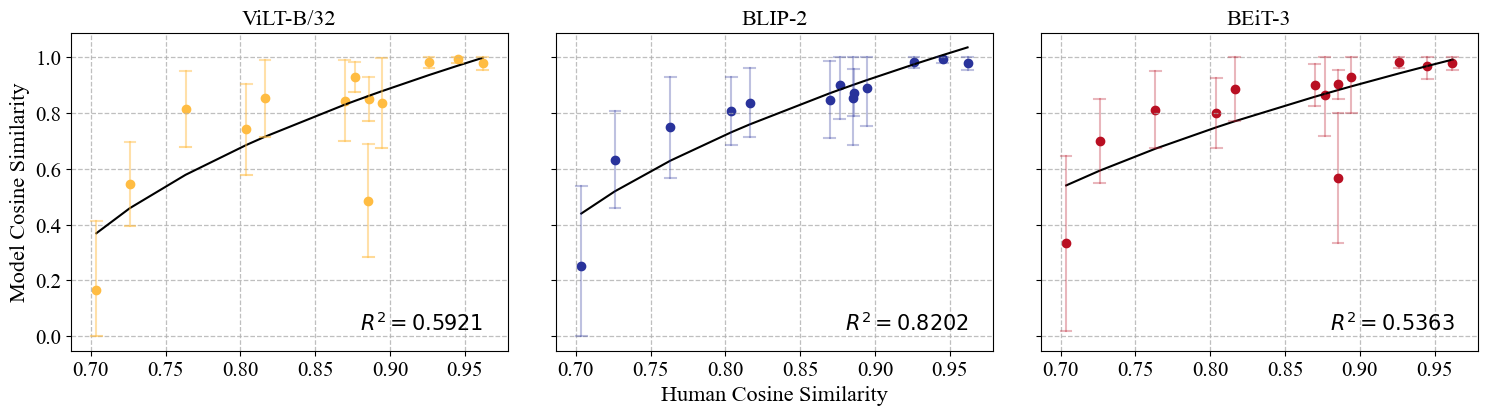

In [76]:
from sklearn.linear_model import LinearRegression

horizontal_line_width = 0.007

plt.rcParams["font.size"] = 15

fig, axes = plt.subplots(1, 3, figsize=(15,4), sharey=True)
plt.tight_layout()

cols = [COLORS["ORANGE"], COLORS["BLUE"], COLORS["RED"]]

for ax, model_str, model_pretty, col in zip(axes, ["vilt", "blip", "beit"], ["ViLT-B/32", "BLIP-2", "BEiT-3"], cols):      
    
    X = grouped_cosine_df["human"].values.flatten().reshape(-1, 1)
    y = grouped_cosine_df[model_str].values.flatten()
    reg = LinearRegression().fit(X, y)
    fit_score = reg.score(X, y)
    slope = reg.coef_
    intercept = reg.intercept_
    
    ## Non-Linear reg
    vals = grouped_cosine_df["human"].values.flatten()
    est_params, est_cov = curve_fit(fct_root, vals, y)
    a, b =  est_params
    print(a, b)

    predicted = [fct_root(x, a, b) for x in vals]

    ax.plot(vals, predicted, zorder=2, color="black")
    
    # Confidence intervals
    
    for mean, rtype, x in zip(grouped_cosine_df[model_str].values, grouped_cosine_df[model_str].index, grouped_cosine_df["human"].values):
        
        _, conf_lower, conf_upper = mean_confidence_interval(perf_df[perf_df["reasoning_type"] == rtype][model_str].values)
        
        left = x - horizontal_line_width / 2
        top = conf_upper
        right = x + horizontal_line_width / 2
        bottom = conf_lower
        
        if top > 1:
            top = 1
        
        if bottom < 0:
            bottom = 0
        
        ax.plot([x, x], [top, bottom], color=col, alpha=0.45 if model_str == "vilt" else 0.3)
        ax.plot([left, right], [top, top], color=col, alpha=0.45 if model_str == "vilt" else 0.3)
        ax.plot([left, right], [bottom, bottom], color=col, alpha=0.45 + 0.1 if model_str == "vilt" else 0.3)

    ax.grid(True, linestyle='--', linewidth=0.9, alpha=0.8, zorder=-1)
    ax.scatter(grouped_cosine_df["human"], grouped_cosine_df[model_str], color=col, label="Data")
    if model_str == "blip":
        ax.set_xlabel("Human Cosine Similarity", size=16)
    ax.set_title(model_pretty, size=16)
    
    if model_str == "vilt":
        ax.set_ylabel("Model Cosine Similarity", size=16)
        
    # ax.text(x=0.88, y=0.02, s=f"$R^2 = {round(fit_score, 4)}{'00' if model_str == 'blip' else ''}$", size=15)
    ax.text(x=0.88, y=0.02, s=f"$R^2 = {str(round(r2_score(y, predicted), 4))}$", size=15)

plt.rcParams["font.size"] = 14
plt.savefig("outputs/plots/transformer_to_human_performance.pdf", bbox_inches='tight')

(array([ 1.,  2.,  1.,  3.,  2.,  2.,  2.,  7.,  2.,  3.,  7.,  5.,  5.,
         9.,  8.,  7., 13., 16., 15., 46.]),
 array([0.37959625, 0.41061644, 0.44163663, 0.47265681, 0.503677  ,
        0.53469719, 0.56571738, 0.59673756, 0.62775775, 0.65877794,
        0.68979813, 0.72081831, 0.7518385 , 0.78285869, 0.81387888,
        0.84489906, 0.87591925, 0.90693944, 0.93795963, 0.96897981,
        1.        ]),
 <BarContainer object of 20 artists>)

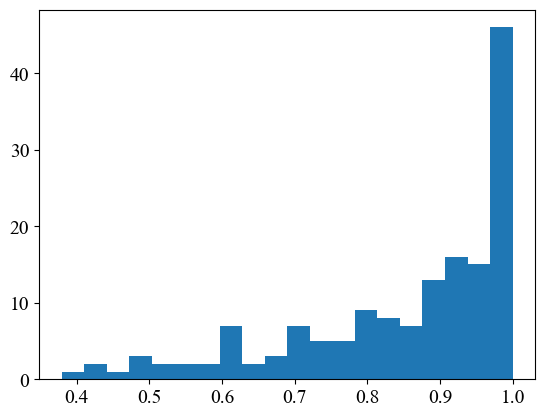

In [22]:
plt.hist(cosine_df["human"], bins=20)

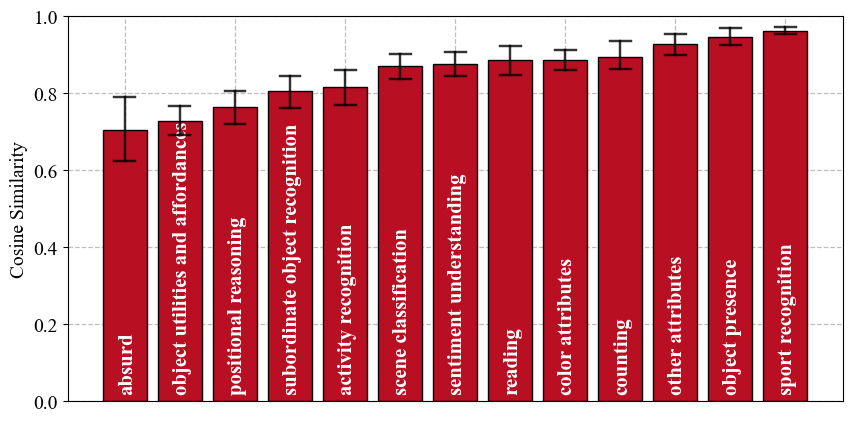

In [16]:
fig, ax= plt.subplots(figsize=(10,5))

ax.grid(True, linestyle='--', linewidth=0.9, alpha=0.8, zorder=-1)
ax.bar(np.array(list(range(len(grouped_cosine_df.index)))), grouped_cosine_df["human"], zorder=2, edgecolor="black", color=COLORS["RED"])
ax.set_ylabel("Cosine Similarity")
ax.set_ylim((0,1))
ax.tick_params(axis="x", direction="in")
ax.set_xticklabels([])

for idx, r in enumerate(grouped_cosine_df.index):
    ax.text(idx - 0.13, 0.03, r, ha="left", color="white", weight="bold", rotation=90, size=15)

relevant_cols = [f"Participant_{x + 1}" for x in range(10)]
human_data_per_reasoning_type = []
horizontal_line_width = 0.38

for idxx, reasoning_t in enumerate(grouped_cosine_df.index):
    human_data_per_reasoning_type.append(cosine_df[cosine_df["reasoning_type"] == reasoning_t][relevant_cols].values.flatten())
                
    nanmean = [x for x in human_data_per_reasoning_type[-1] if not np.isnan(x)]
    _, conf_lower, conf_upper = mean_confidence_interval(nanmean)

    left = idxx - horizontal_line_width / 2
    top = conf_upper
    right = idxx + horizontal_line_width / 2
    bottom = conf_lower

    ax.plot([idxx, idxx], [top, bottom], color="black", alpha=0.8, zorder=4, linewidth=1.75)
    ax.plot([left, right], [top, top], color="black", alpha=0.8, zorder=4, linewidth=1.75)
    ax.plot([left, right], [bottom, bottom], color="black", alpha=0.8, zorder=4, linewidth=1.75)

plt.savefig("outputs/plots/human_performance_reasoning_types_otherdir.pdf", bbox_inches="tight")

### Compute similarity

In [133]:
event_df[event_df["event"] == "fixation"]

question_id  trial_id    start      end duration  x_start  y_start  \
0        175718005         0  5260111  5260889      779   1283.5    727.0   
1        175718005         0  5260914  5261607      694   1377.5    797.7   
3        420775001         1  5271693  5272236      544   1283.7    724.1   
4        420775001         1  5272263  5273182      920   1541.3    684.0   
5        420775001         1  5273206  5273367      162   1424.4    770.5   
...            ...       ...      ...      ...      ...      ...      ...   
46038    353446000        77  1692160  1692332      173   1046.1   1018.2   
46039    353446000        77  1692399  1692576      178   1753.8    948.2   
46040    353446000        77  1692738  1692819       82   1526.5    934.5   
46041    353446000        77  1692852  1693073      222   1131.0    958.6   
46042    353446000        77  1693108  1693263      156   1241.0    938.3   

        x_end   y_end     event  image_x_start  image_y_start  image_x_end  \
0      1283.5   727.0  fixation          963.5          647.0        963.5   
1      1377.5   797.7  fixation         1057.5          717.7       1057.5   
3      1283.7   724.1  fixation          963.7          646.1        963.7   
4      1541.3   684.0  fixation         1221.3          606.0       1221.3   
5      1424.4   770.5  fixation         1104.4          692.5       1104.4   
...       ...     ...       ...            ...            ...          ...   
46038  1046.1  1018.2  fixation          582.1          910.2        582.1   
46039  1753.8   948.2  fixation         1289.8          840.2       1289.8   
46040  1526.5   934.5  fixation         1062.5          826.5       1062.5   
46041  1131.0   958.6  fixation          667.0          850.6        667.0   
46042  1241.0   938.3  fixation          777.0          830.3        777.0   

       image_y_end vp_code  
0            647.0  PI01CH  
1            717.7  PI01CH  
3            646.1  PI01CH  
4            606.0  PI01CH  
5            692.5  PI01CH  
...            ...     ...  
46038        910.2  ED01IM  
46039        840.2  ED01IM  
46040        826.5  ED01IM  
46041        850.6  ED01IM  
46042        830.3  ED01IM  

[22958 rows x 15 columns]

In [23]:
vilt_scores = {"corr": [], "kldiv": [], "aucs": [], "nsss": []}
blip_scores = {"corr": [], "kldiv": [], "aucs": [], "nsss": []}
beit_scores = {"corr": [], "kldiv": [], "aucs": [], "nsss": []}

vilt_att, _, _ = loader.load_model_results("vilt")
blip_att, _, _ = loader.load_model_results("blip")
beit_att, _, _ = loader.load_model_results("beit3")

gaze_df, event_df, logger_df = loader.load_participant_data()
valid_fixations = dutil.get_fixation_df(event_df)
        
for q_id in logger_df["question_id"].value_counts().index:
    
    vilt_map = vilt_att[str(q_id)]
    blip_map = blip_att[str(q_id)]
    beit_map = beit_att[str(q_id)]
    
    for model_map, model_scores in zip([vilt_map, blip_map, beit_map], [vilt_scores, blip_scores, beit_scores]):
        
        # Compute human low-res heatmap with matching shape
        low_res_heatmap = hmaps.compute_low_res_human_heatmap(valid_fixations, logger_df, q_id, att_map_shape=model_map.shape, reduction=np.mean)
    
        # Compute similarity scores and append
        
        model_scores["corr"].append(rank_correlation(model_map, low_res_heatmap))
        model_scores["kldiv"].append(new_kl_div(model_map, low_res_heatmap))
        model_scores["aucs"].append(auc_judd(model_map, low_res_heatmap))
        model_scores["nsss"].append(nss(model_map, low_res_heatmap))

vilt_similarity_df = pd.DataFrame.from_dict(vilt_scores)
vilt_similarity_df["kldiv"] = vilt_similarity_df["kldiv"] + 1
blip_similarity_df = pd.DataFrame.from_dict(blip_scores)
beit_similarity_df = pd.DataFrame.from_dict(beit_scores)

vilt_similarity_df["question_id"] = logger_df["question_id"].value_counts().index
blip_similarity_df["question_id"] = logger_df["question_id"].value_counts().index
beit_similarity_df["question_id"] = logger_df["question_id"].value_counts().index

D:\6.Semester\Bachelorthesis\ba-visual-question-answering\util\data_util.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixations["close"] = fixations[["x_start", "y_start"]].apply(helper, axis=1)
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answe

D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))


D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))


D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))


D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))


D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))


D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))


D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))


D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))


D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))


D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))


D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))


D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))
D:\6.Semester\Bachelorthesis\ba-visual-question-answering\eval\heatmap_comparison_metrics.py:31: RuntimeWarning: divide by zero encountered in log
  log_density_2 = np.log(convert_saliency_map_to_density(saliency_map_2, minimum_value=minimum_value))


In [10]:
round(beit_similarity_df.mean(), 4)

corr           1.298000e-01
kldiv          2.844100e+00
aucs           6.587000e-01
nsss           4.210000e-01
question_id    2.854055e+08
dtype: float64

In [16]:
round(vilt_similarity_df.std(), 4).apply(lambda x: "{:f}".format(x))

corr                   0.068200
kldiv                  0.574400
aucs                   0.055000
nsss                   0.163000
question_id    172888674.272400
dtype: object

In [26]:
# Load annotations
a = loader.load_experiment_questions_for_group(1, only_values=False)
b = loader.load_experiment_questions_for_group(2, only_values=False)
reasoning_type_df = pd.concat([a, b])

for df in [vilt_similarity_df, blip_similarity_df, beit_similarity_df]:
    df["reasoning_type"] = df["question_id"].apply(lambda q_id: reasoning_type_df.isin([q_id]).any()[reasoning_type_df.isin([q_id]).any() == True].index[0])

grouped_vilt = vilt_similarity_df.groupby("reasoning_type").mean()
grouped_blip = blip_similarity_df.groupby("reasoning_type").mean()
grouped_beit = beit_similarity_df.groupby("reasoning_type").mean()

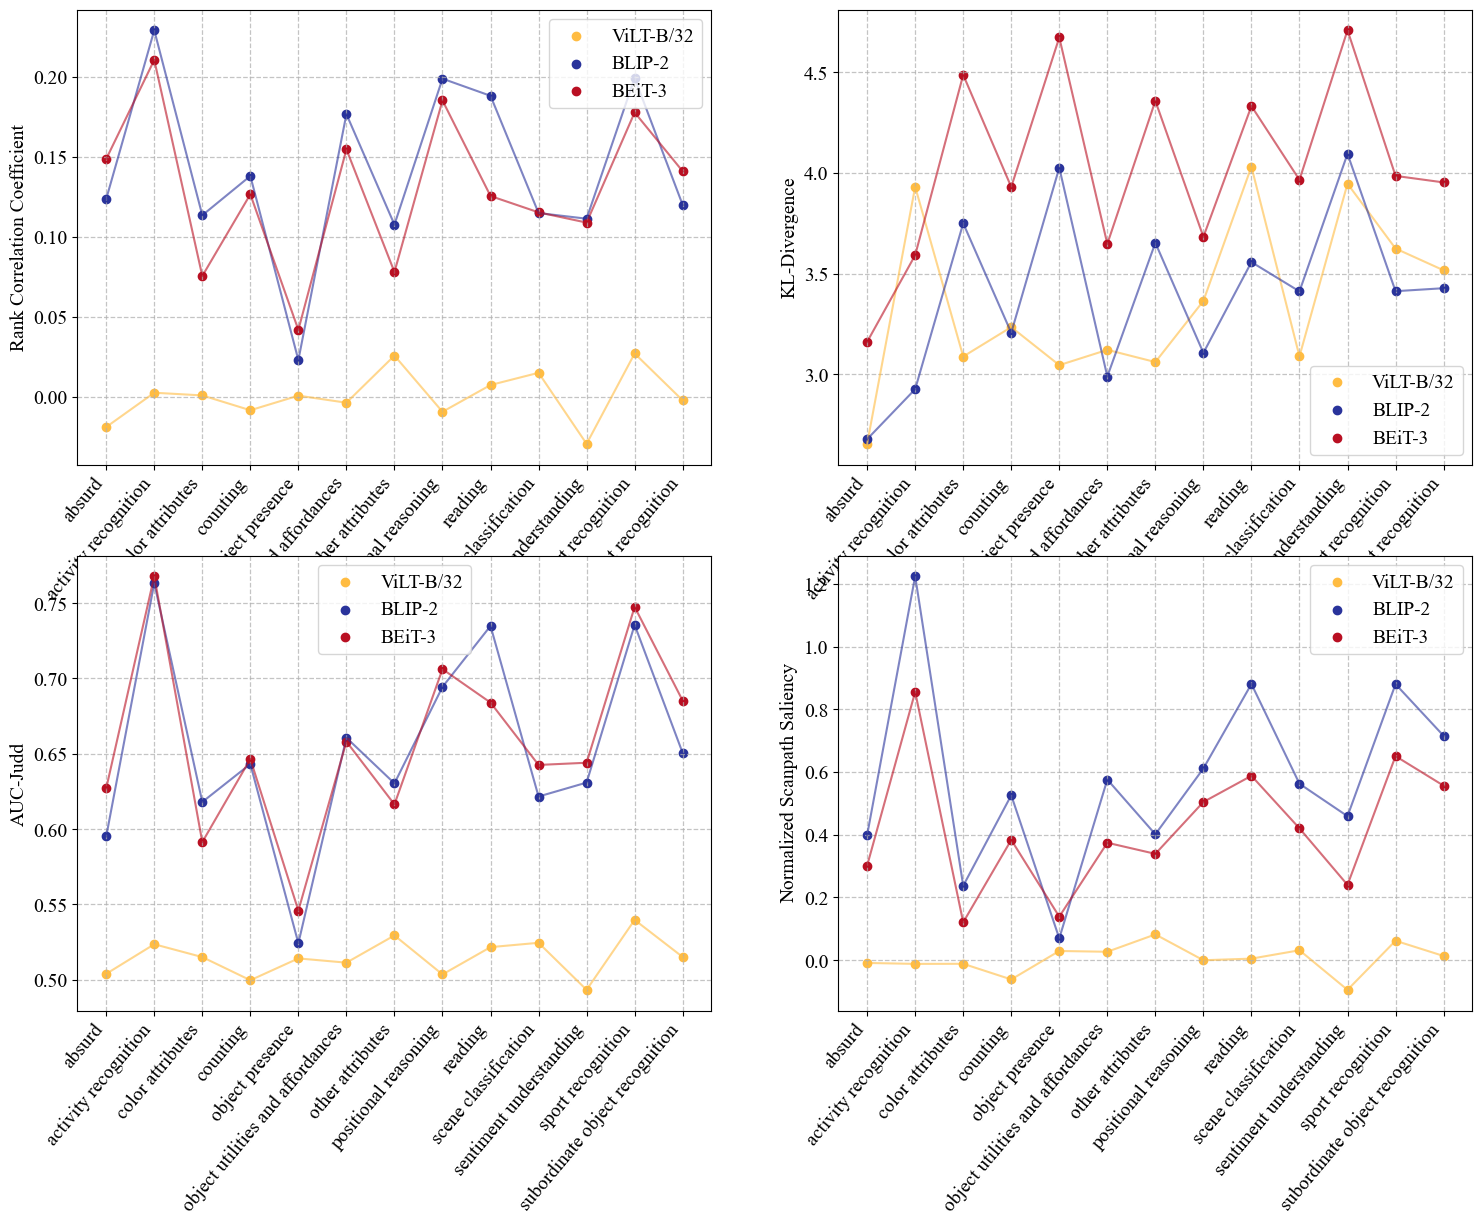

In [106]:
fig, axes = plt.subplots(2, 2, figsize=(18, 13))
flattened_axes = np.array(axes).flatten()


for ax, metric, lab in zip(flattened_axes, ["corr", "kldiv", "aucs", "nsss"], ["Rank Correlation Coefficient", "KL-Divergence", "AUC-Judd", "Normalized Scanpath Saliency"]):
    for df, col, model_str in zip([grouped_vilt, grouped_blip, grouped_beit], [COLORS["ORANGE"], COLORS["BLUE"], COLORS["RED"]], ["ViLT-B/32", "BLIP-2", "BEiT-3"]):
        ax.scatter(df[metric].index, df[metric].values, label=model_str, color=col)
        ax.plot(df[metric], "-", color=col,  alpha=0.6)
        
    ax.set_xticks(ax.get_xticks(), labels=ax.get_xticklabels(), rotation=50, ha="right")
    ax.set_ylabel(lab)
    ax.grid(True, linestyle='--', linewidth=0.9, alpha=0.75, zorder=-1)
    ax.legend()

In [44]:
a = blip_similarity_df[blip_similarity_df["reasoning_type"] == "reading"]["corr"].values
b = beit_similarity_df[beit_similarity_df["reasoning_type"] == "reading"]["corr"].values.tolist()
b.extend(vilt_similarity_df[vilt_similarity_df["reasoning_type"] == "reading"]["corr"].values)

In [46]:
scipy.stats.ttest_ind(a, b)

Ttest_indResult(statistic=3.060148588569494, pvalue=0.004298339898518993)

In [29]:
df = blip_similarity_df

populations = []

for r_type in grouped_blip.index.values:
    populations.append(df[df["reasoning_type"] == r_type]["corr"].values)
    
scipy.stats.f_oneway(*tuple(populations))

F_onewayResult(statistic=2.2924556488789394, pvalue=0.010663452689542793)

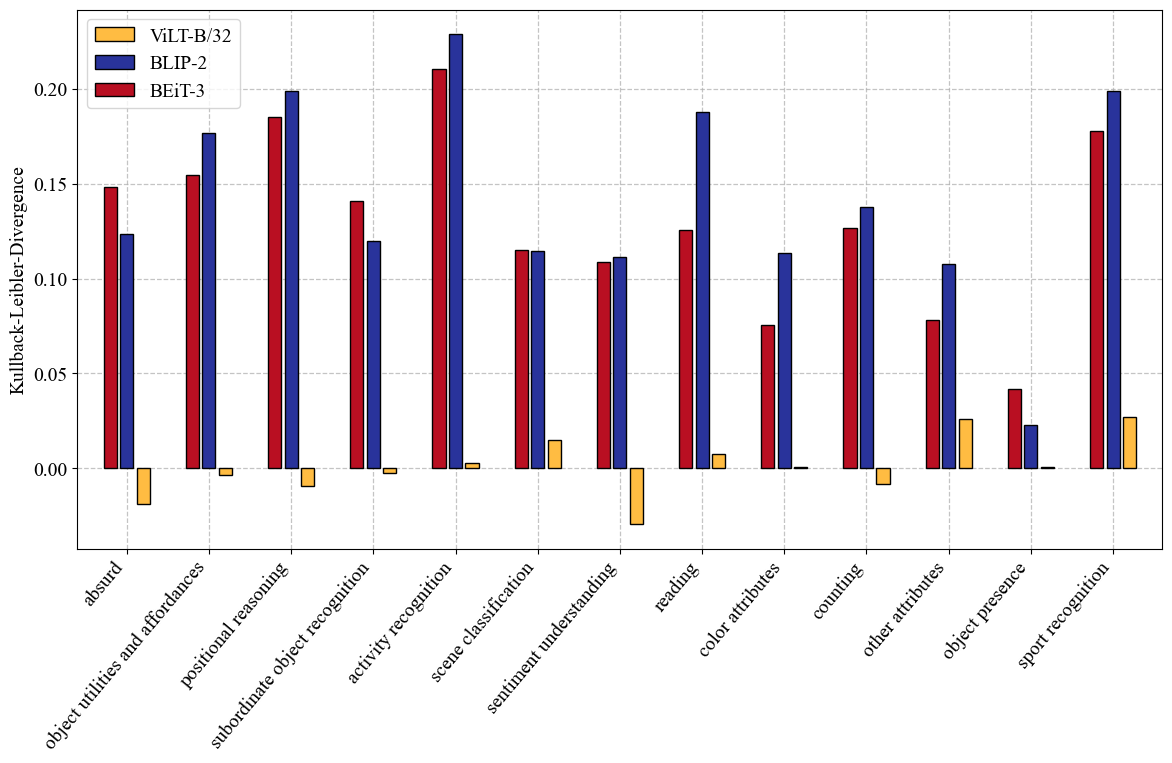

In [134]:
fig, ax = plt.subplots(figsize=(14,7))
order = grouped_cosine_df.sort_values(by="human").index.values.tolist() 
# order = grouped_cosine_df.sort_values(by="beit").index.values.tolist() # for grouping after transformer best scores
metric = ["corr", "kldiv", "aucs", "nsss"][0]
ylabel = ["Rank Correlation Coefficient $R^2$", "Kullback-Leibler-Divergence", "AUC-Judd", "Normalized Scanpath Saliency"][1]

horizontal_line_width = 0.5

plt.grid(True, linestyle='--', linewidth=0.9, alpha=0.75, zorder=-1)
plt.ylabel(ylabel)
tick_lst = [5 * x for x in range(len(order))]
tick_label_lst = order
plt.xticks(tick_lst, labels=tick_label_lst, rotation=50, ha="right")
plt.xlim((-3, 63))

cols = [COLORS["ORANGE"], COLORS["BLUE"], COLORS["RED"]]
for df, model_str, offset, col, rtype_df in zip([grouped_vilt, grouped_blip, grouped_beit], ["ViLT-B/32", "BLIP-2", "BEiT-3"], [1, 0, -1], cols, [vilt_similarity_df, blip_similarity_df, beit_similarity_df]):
    
    # Bars
    df = df.loc[order]
    plt.bar(np.array(list(range(len(df.index)))) * 5 + offset, df[metric].values, zorder=2, edgecolor="black", label=model_str, color=col)

    # Cut off if AUC-Judd
    if metric == "aucs":
        ax.set_ylim((0.5, 1))
        
    # Plot confidence intervals
    '''
    for idxx, rtype in enumerate(df.index.values):
        
        idxx = idxx * 5 + offset
        _, conf_lower, conf_upper = mean_confidence_interval(rtype_df[rtype_df["reasoning_type"] == rtype][metric].values)

        left = idxx - horizontal_line_width / 2
        top = conf_upper
        right = idxx + horizontal_line_width / 2
        bottom = conf_lower

        ax.plot([idxx, idxx], [top, bottom], color="black", alpha=0.8, zorder=4, linewidth=1.75)
        ax.plot([left, right], [top, top], color="black", alpha=0.8, zorder=4, linewidth=1.75)
        ax.plot([left, right], [bottom, bottom], color="black", alpha=0.8, zorder=4, linewidth=1.75)
    '''
    
plt.legend()
plt.savefig(f"outputs/plots/similarity_{metric}.pdf", bbox_inches="tight")

In [81]:
perf_dfs = loader.load_computed_performance_scores()
accuracy_df, vqav2_df, wu_palmer_df, cosine_df = perf_dfs

vilt_similarity_df["performance"] = vilt_similarity_df["question_id"].apply(lambda q_id: cosine_df[cosine_df["question_id"] == q_id]["vilt"].values[0])
blip_similarity_df["performance"] = blip_similarity_df["question_id"].apply(lambda q_id: cosine_df[cosine_df["question_id"] == q_id]["blip"].values[0])
beit_similarity_df["performance"] = beit_similarity_df["question_id"].apply(lambda q_id: cosine_df[cosine_df["question_id"] == q_id]["beit"].values[0])

a = loader.load_experiment_questions_for_group(1, only_values=False)
b = loader.load_experiment_questions_for_group(2, only_values=False)
reasoning_type_df = pd.concat([a, b])

for df in [vilt_similarity_df, blip_similarity_df, beit_similarity_df]:
    df["reasoning_type"] = df["question_id"].apply(lambda q_id: reasoning_type_df.isin([q_id]).any()[reasoning_type_df.isin([q_id]).any() == True].index[0])


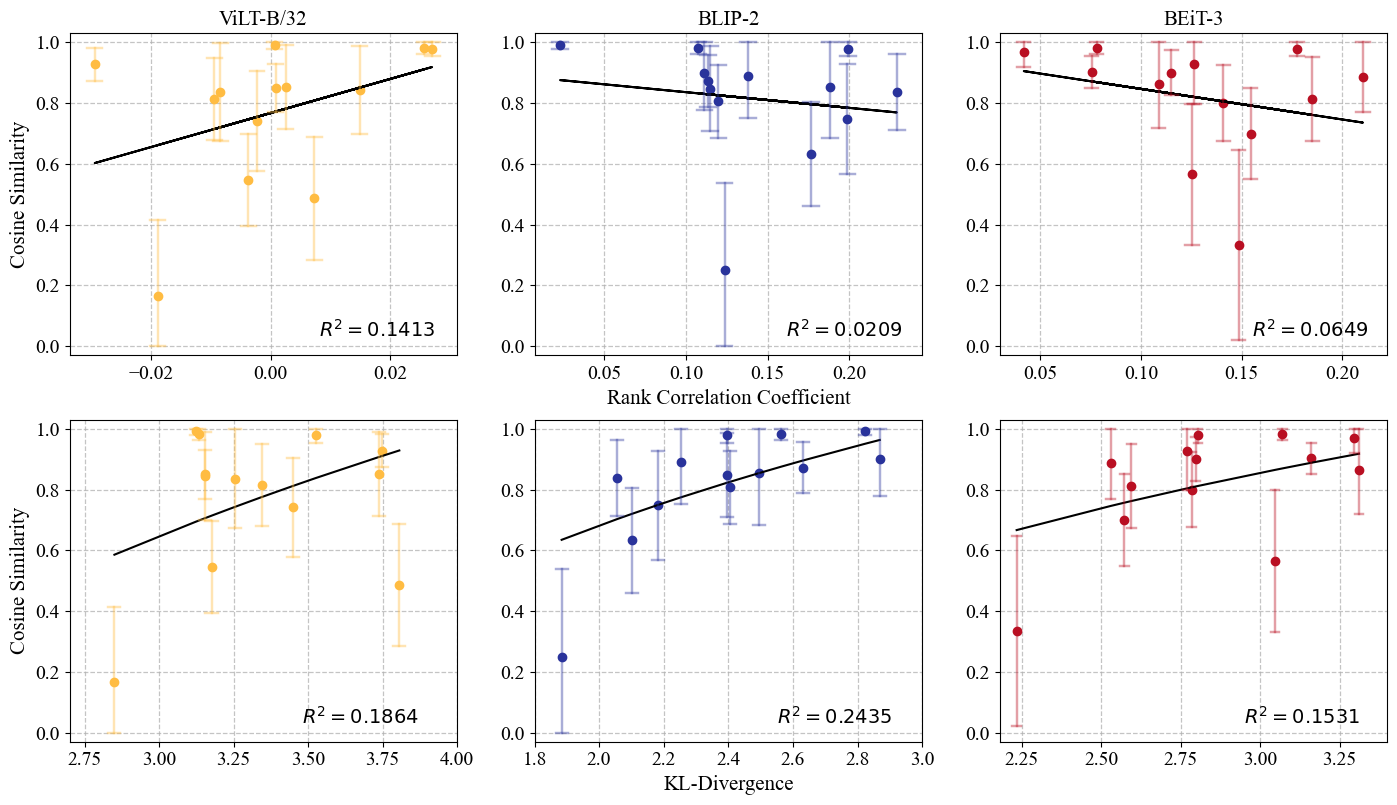

In [107]:
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

dfs = [vilt_similarity_df.groupby("reasoning_type").mean(), blip_similarity_df.groupby("reasoning_type").mean(), beit_similarity_df.groupby("reasoning_type").mean()]
ungrouped_dfs = [vilt_similarity_df, blip_similarity_df, beit_similarity_df]
model_names = ["ViLT-B/32", "BLIP-2", "BEiT-3"]
cols = [COLORS["ORANGE"], COLORS["BLUE"], COLORS["RED"]]

def fct(x, a, b):
    return a + b * np.log(x)

def fct_root(x, a, b):
    return a *  np.sqrt(x + b)

fig, axes = plt.subplots(2, 3, figsize=(17, 9.2))

for idx, (df, ungrouped_df, name, col) in enumerate(zip(dfs, ungrouped_dfs, model_names, cols)):
    
    horizontal_line_width = [0.0025, 0.0095, 0.0065][idx]
    
    ax1, ax2 = axes[:, idx]
    ax1.grid(True, linestyle='--', linewidth=0.9, alpha=0.75, zorder=-1)
    ax2.grid(True, linestyle='--', linewidth=0.9, alpha=0.75, zorder=-1)
    
    ax1.set_title(name, size=15)
    
    if idx == 0:
        ax1.set_ylabel("Cosine Similarity", size=15)
        ax2.set_ylabel("Cosine Similarity", size=15)
        
    if idx == 1:
        ax1.set_xlabel("Rank Correlation Coefficient", size=15)
        ax2.set_xlabel("KL-Divergence", size=15)
        
    ax1.scatter(df["corr"], df["performance"], zorder=2, color=col, label="Data")
    ax2.scatter(df["kldiv"], df["performance"], zorder=2, color=col, label="Data")
    ax1.set_ylim((-0.03, 1 + 0.03))
    ax2.set_ylim((-0.03, 1 + 0.03))
    
    for r_type in df.index:
        
        r_data = ungrouped_df[ungrouped_df["reasoning_type"] == r_type]["performance"].values.flatten()
        idxx = df.loc[r_type]["corr"]
        
        _, conf_lower, conf_upper = mean_confidence_interval(r_data)

        left = idxx - horizontal_line_width / 2
        top = conf_upper
        right = idxx + horizontal_line_width / 2
        bottom = conf_lower
        
        if top > 1:
            top = 1
            
        if bottom < 0:
            bottom = 0

        ax1.plot([idxx, idxx], [top, bottom], color=col, alpha=0.4, zorder=4, linewidth=1.75)
        ax1.plot([left, right], [top, top], color=col, alpha=0.4, zorder=4, linewidth=1.75)
        ax1.plot([left, right], [bottom, bottom], color=col, alpha=0.4, zorder=4, linewidth=1.75)
        
        idxx = df.loc[r_type]["kldiv"]
        
        left = idxx - horizontal_line_width * [8.1, 1.95, 2.1][idx]
        right = idxx + horizontal_line_width * [8.1, 1.95, 2.1][idx]

        ax2.plot([idxx, idxx], [top, bottom], color=col, alpha=0.4, zorder=4, linewidth=1.75)
        ax2.plot([left, right], [top, top], color=col, alpha=0.4, zorder=4, linewidth=1.75)
        ax2.plot([left, right], [bottom, bottom], color=col, alpha=0.4, zorder=4, linewidth=1.75)

    vals = sorted(df["kldiv"].values)
    ground_truth = df["performance"].values
    
    reg = LinearRegression().fit(df["corr"].values.reshape(-1, 1), ground_truth)
    fit_score = reg.score(df["corr"].values.reshape(-1, 1), ground_truth)
    slope = reg.coef_
    intercept = reg.intercept_
    ax1.plot(df["corr"].values, slope * df["corr"].values + intercept, color="black", label=f"Regression with $R^2 \approx $ {round(fit_score, 4)}")

    est_params, est_cov = curve_fit(fct, vals, ground_truth)
    a, b =  est_params

    predicted = [fct(x, a, b) for x in vals]

    ax2.plot(vals, predicted, zorder=2, color="black", label=f"Regression with $R^2 \approx $ {round(r2_score(ground_truth, predicted), 4)}")
    
    ax1.text(x=[0.008, 0.161, 0.155][idx], y=0.03, s=f"$R^2 = {round(fit_score, 4)} $", size=14)
    ax2.text(x=[3.48, 2.55, 2.95][idx], y=0.03, s=f"$R^2 = {round(r2_score(ground_truth, predicted), 4)} $", size=14)
    
    ax2.set_xlim([(2.7, 4), (1.8, 3), (2.18, 3.4)][idx])
    
plt.savefig(f"outputs/plots/similaritypredictsperformance.pdf", bbox_inches="tight")

### Neurophysiology

In [142]:
gaze_df, event_df, logger_df = loader.load_participant_data()

a = loader.load_experiment_questions_for_group(1, only_values=False)
b = loader.load_experiment_questions_for_group(2, only_values=False)
reasoning_type_df = pd.concat([a, b])

reasoning_type_lookup = {}

for col in reasoning_type_df.columns:
    for x in reasoning_type_df[col].values:
        reasoning_type_lookup[x] = col
        
logger_df["reasoning_type"] = logger_df["question_id"].apply(lambda q_id: reasoning_type_df.isin([q_id]).any()[reasoning_type_df.isin([q_id]).any() == True].index[0])
gaze_df["reasoning_type"] = gaze_df["question_id"].apply(lambda q_id: reasoning_type_lookup[q_id])

perf_dfs = loader.load_computed_performance_scores()
accuracy_df, vqav2_df, wu_palmer_df, cosine_df = perf_dfs
cosine_df["human"] = cosine_df[[f"Participant_{x + 1}" for x in range(10)]].mean(axis=1)
grouped_cosine_df = cosine_df.groupby("reasoning_type").mean().sort_values(by=["human"])
difficulty_order = grouped_cosine_df.index

In [143]:
blinks_df = event_df[event_df["event"] == "blink"]

def find_blinks_for_qid_and_vp(entry):
    q_id = entry["question_id"]
    time_on_img = entry["time_on_image"] / 1000
    vp_code = entry["vp_code"]
    
    num_blinks = blinks_df[(blinks_df["question_id"] == q_id) & (blinks_df["vp_code"] == vp_code)].shape[0]
    return num_blinks / time_on_img
    
logger_df["blink_rate"] = logger_df.apply(lambda x: find_blinks_for_qid_and_vp(x), axis=1)
grouped_gaze_df = gaze_df.groupby("reasoning_type").mean().loc[difficulty_order]

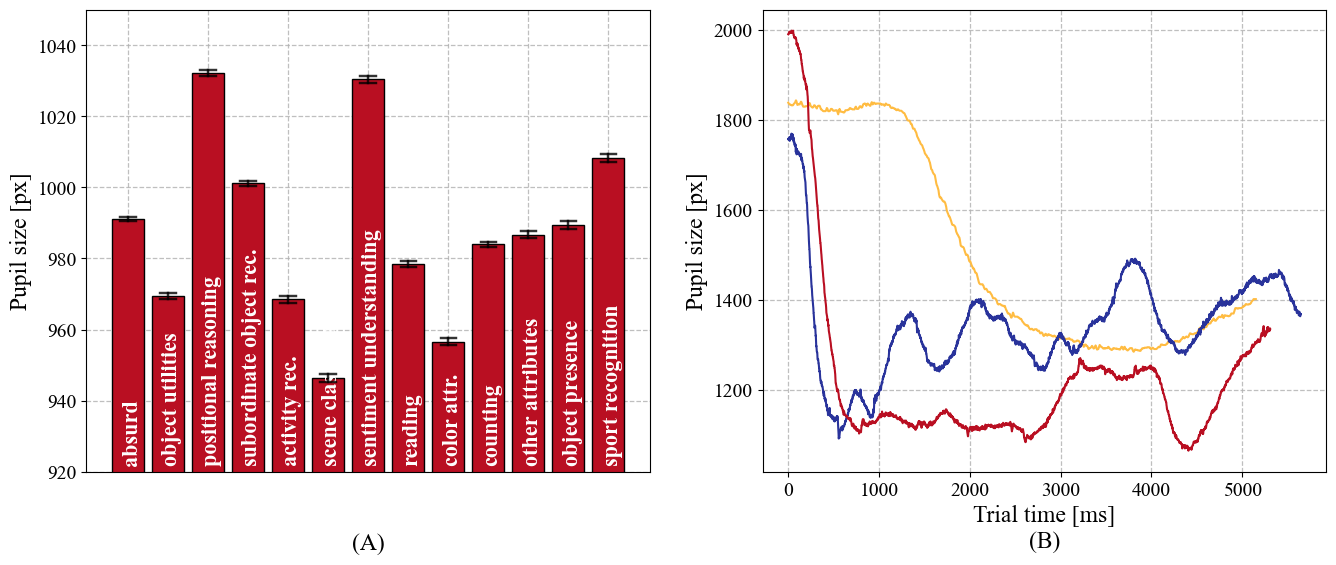

In [150]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

grouped_df = logger_df.groupby("reasoning_type").mean().loc[difficulty_order]

ax1.grid(True, linestyle='--', linewidth=0.9, alpha=0.8, zorder=-1)
ax1.bar(np.array(list(range(len(grouped_gaze_df.index)))), grouped_gaze_df["pupil_size"], zorder=2, edgecolor="black", color=COLORS["RED"])
ax1.set_ylabel("Pupil size [px]", size=17)
ax1.tick_params(axis="x", direction="in")
ax1.set_xticklabels([])
ax1.set_ylim((920, 1050))
for idx, r in enumerate(grouped_df.index):
    if "object utilities" in r:
        r = "object utilities"
    if "activity" in r:
        r = "activity rec."
    if "color" in r:
        r = "color attr."
    if "subordinate" in r:
        r = "subordinate object rec."
    ax1.text(idx - 0.14, 923, r, ha="left", color="white", weight="bold", rotation=90, size=16)

cols = [COLORS["ORANGE"], COLORS["BLUE"], COLORS["RED"]]

sl1 = gaze_df[(gaze_df["trial_id"] == 0) & (gaze_df["vp_code"] == "PI01CH")]
sl2 = gaze_df[(gaze_df["trial_id"] == 2) & (gaze_df["vp_code"] == "PI01CH")]
sl3 = gaze_df[(gaze_df["trial_id"] == 8) & (gaze_df["vp_code"] == "PI01CH")]
ax2.plot(np.array(range(sl1.shape[0])) * 5, sl1["pupil_size"], color=cols[0])
ax2.plot(np.array(range(sl2.shape[0])) * 0.75, sl2["pupil_size"], color=cols[1])
ax2.plot(range(sl3.shape[0]), sl3["pupil_size"], color=cols[2])
ax2.grid(True, linestyle='--', linewidth=0.9, alpha=0.8, zorder=-1)

ax1.set_xlabel("\n\n(A)", size=17)
ax2.set_xlabel("Trial time [ms]\n(B)", size=17)
ax2.set_ylabel("Pupil size [px]", size=17)
horizontal_line_width = 0.38

for idxx, rtype in enumerate(difficulty_order):
    
    data = gaze_df[gaze_df["reasoning_type"] == rtype]["pupil_size"]
    _, conf_lower, conf_upper = mean_confidence_interval(data)

    left = idxx - horizontal_line_width / 2
    top = conf_upper
    right = idxx + horizontal_line_width / 2
    bottom = conf_lower

    ax1.plot([idxx, idxx], [top, bottom], color="black", alpha=0.8, zorder=4, linewidth=1.75)
    ax1.plot([left, right], [top, top], color="black", alpha=0.8, zorder=4, linewidth=1.75)
    ax1.plot([left, right], [bottom, bottom], color="black", alpha=0.8, zorder=4, linewidth=1.75)
    
    
plt.savefig(f"outputs/plots/pupilsizes.pdf", bbox_inches="tight")

In [64]:
from sklearn.linear_model import LinearRegression

X = grouped_df["saccade_extent"].values
y = grouped_cosine_df["human"].values
reg = LinearRegression().fit(X.reshape(-1, 1), y)
fit_score = reg.score(X.reshape(-1, 1), y)
slope = reg.coef_
intercept = reg.intercept_

print(fit_score)
print(slope, intercept)

0.001845975671301514
[9.18109886e-05] 0.8245861202989008


In [160]:
saccade_df = event_df[event_df["event"] == "saccade"]
saccade_df["saccade_extent"] = np.sqrt(np.power(saccade_df["x_end"] - saccade_df["x_start"], 2) + np.power(saccade_df["y_end"] - saccade_df["y_start"], 2)) 
saccade_df["reasoning_type"] = saccade_df["question_id"].apply(lambda q_id: reasoning_type_lookup[q_id])

C:\Users\bock-\AppData\Local\Temp\ipykernel_1240\1355885603.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  saccade_df["saccade_extent"] = np.sqrt(np.power(saccade_df["x_end"] - saccade_df["x_start"], 2) + np.power(saccade_df["y_end"] - saccade_df["y_start"], 2))
C:\Users\bock-\AppData\Local\Temp\ipykernel_1240\1355885603.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  saccade_df["reasoning_type"] = saccade_df["question_id"].apply(lambda q_id: reasoning_type_lookup[q_id])


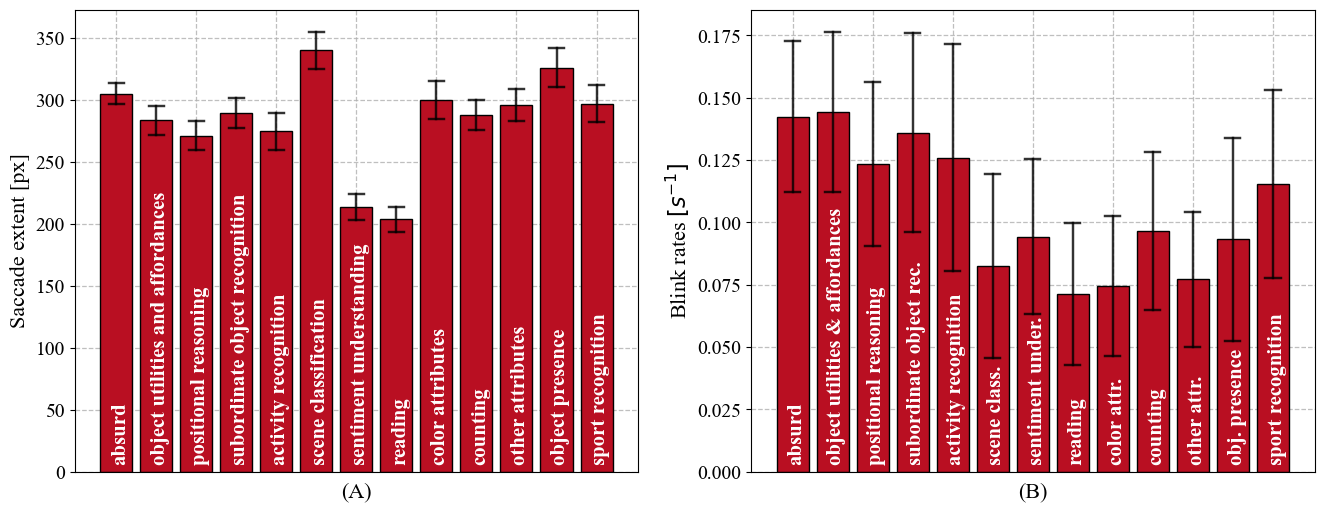

In [162]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

grouped_df = saccade_df.groupby("reasoning_type").mean().loc[difficulty_order]

ax1.grid(True, linestyle='--', linewidth=0.9, alpha=0.8, zorder=-1)
ax1.bar(np.array(list(range(len(grouped_df.index)))), grouped_df["saccade_extent"], zorder=2, edgecolor="black", color=COLORS["RED"])
ax1.set_ylabel("Saccade extent [px]", size=16)
ax1.tick_params(axis="x", direction="in")
ax1.set_xticklabels([])

grouped_df_blink = logger_df.groupby("reasoning_type").mean().loc[difficulty_order]

ax2.grid(True, linestyle='--', linewidth=0.9, alpha=0.8, zorder=-1)
ax2.bar(np.array(list(range(len(grouped_df_blink.index)))), grouped_df_blink["blink_rate"], zorder=2, edgecolor="black", color=COLORS["RED"])
ax2.set_ylabel("Blink rates $[s^{-1}]$", size=16)
ax2.tick_params(axis="x", direction="in")
ax2.set_xticklabels([])

for idx, r in enumerate(grouped_df.index):
    ax1.text(idx - 0.13, 10, r, ha="left", color="white", weight="bold", rotation=90, size=15)
    if "utilities" in r:
        r = "object utilities & affordances"
        
    if "subordinate" in r:
        r = "subordinate object rec."
        
    if "scene class" in r:
        r = "scene class."
        
    if "sentiment under" in r:
        r = "sentiment under."
    
    if "color attr" in r:
        r = "color attr."
    
    if "other attr" in r:
        r = "other attr."
        
    if "object prese" in r:
        r = "obj. presence"
        
    ax2.text(idx - 0.13, 0.005, r, ha="left", color="white", weight="bold", rotation=90, size=15)

horizontal_line_width = 0.38

for idxx, rtype in enumerate(difficulty_order):
    data = saccade_df[saccade_df["reasoning_type"] == rtype]["saccade_extent"]
    _, conf_lower, conf_upper = mean_confidence_interval(data)

    left = idxx - horizontal_line_width / 2
    top = conf_upper
    right = idxx + horizontal_line_width / 2
    bottom = conf_lower

    ax1.plot([idxx, idxx], [top, bottom], color="black", alpha=0.8, zorder=4, linewidth=1.75)
    ax1.plot([left, right], [top, top], color="black", alpha=0.8, zorder=4, linewidth=1.75)
    ax1.plot([left, right], [bottom, bottom], color="black", alpha=0.8, zorder=4, linewidth=1.75)
    
    data = logger_df[logger_df["reasoning_type"] == rtype]["blink_rate"]
    _, conf_lower, conf_upper = mean_confidence_interval(data)
    
    left = idxx - horizontal_line_width / 2
    top = conf_upper
    right = idxx + horizontal_line_width / 2
    bottom = conf_lower

    ax2.plot([idxx, idxx], [top, bottom], color="black", alpha=0.8, zorder=4, linewidth=1.75)
    ax2.plot([left, right], [top, top], color="black", alpha=0.8, zorder=4, linewidth=1.75)
    ax2.plot([left, right], [bottom, bottom], color="black", alpha=0.8, zorder=4, linewidth=1.75)
    
    ax1.set_xlabel("(A)", size=16)
    ax2.set_xlabel("(B)", size=16)
    
plt.savefig(f"outputs/plots/saccadesandblinks.pdf", bbox_inches="tight")

In [60]:
reasoning_categories_data = tuple([saccade_df[saccade_df["reasoning_type"] == r_type]["saccade_extent"].values for r_type in grouped_df.index.values])
print(reasoning_categories_data)
scipy.stats.f_oneway(*reasoning_categories_data)

(array([448.80272949, 126.9400646 ,  25.46566316, ..., 131.79719269,
       975.54908129, 113.36300102]), array([ 44.08559856, 383.85764288, 774.64224646, ..., 740.2631424 ,
       740.43063146, 119.52376333]), array([  47.00478699,  250.82115142,  275.82371182, ..., 1111.3268871 ,
        301.92093336,  319.51095443]), array([118.92691033, 274.05612564, 428.5749876 , ..., 403.60159811,
       101.43460948, 436.75559527]), array([151.49719469, 143.05918356,  84.79174488, ..., 617.17654686,
       525.3867623 ,  86.40677057]), array([248.02961517, 123.02235569, 205.40910399, ..., 550.18270602,
        65.52289676, 562.93005782]), array([267.39827973,  17.37613306,  23.91756677, ...,  72.49586195,
       405.98445783, 389.40653564]), array([116.58855004,  65.90789027, 686.26205636, ...,  23.45548976,
        37.87822594,  42.88414625]), array([155.72491772, 281.75141526, 631.00412835, ...,  74.56889432,
       246.30990642, 165.45588536]), array([104.56715546, 279.05334615, 242.38153808,

F_onewayResult(statistic=33.23034859387049, pvalue=3.79129669463514e-77)

### Predictors of Performance

In [65]:
perf_dfs = loader.load_computed_performance_scores()
accuracy_df, vqav2_df, wu_palmer_df, cosine_df = perf_dfs
cosine_df["human"] = cosine_df.apply(lambda entry: np.nanmean(entry[[f"Participant_{x + 1}" for x in range(10)]]), axis=1)

In [105]:
fit = ols('beit ~ C(reasoning_type)', data=cosine_df).fit()
fit.summary()
# 1.69e-05 # 1.69e-19 # 6.24e-13 # 1.69e-11

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   beit   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     8.121
Date:                Sun, 30 Jul 2023   Prob (F-statistic):           1.69e-11
Time:                        19:19:17   Log-Likelihood:                 16.200
No. Observations:                 156   AIC:                            -6.400
Df Residuals:                     143   BIC:                             33.25
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                                 0.3333      0.066      5.069      0.000       0.203       0.463
C(reasoning_type)[T.activity recognition]                 0.5529      0.093      5.946      0.000       0.369       0.737
C(reasoning_type)[T.color attributes]                     0.5691      0.093      6.119      0.000       0.385       0.753
C(reasoning_type)[T.counting]                             0.5949      0.093      6.397      0.000       0.411       0.779
C(reasoning_type)[T.object presence]                      0.6363      0.093      6.842      0.000       0.453       0.820
C(reasoning_type)[T.object utilities and affordances]     0.3664      0.093      3.940      0.000       0.183       0.550
C(reasoning_type)[T.other attributes]                     0.6482      0.093      6.970      0.000       0.464       0.832
C(reasoning_type)[T.positional reasoning]                 0.4790      0.093      5.151      0.000       0.295       0.663
C(reasoning_type)[T.reading]                              0.2321      0.093      2.496      0.014       0.048       0.416
C(reasoning_type)[T.scene classification]                 0.5672      0.093      6.099      0.000       0.383       0.751
C(reasoning_type)[T.sentiment understanding]              0.5298      0.093      5.697      0.000       0.346       0.714
C(reasoning_type)[T.sport recognition]                    0.6455      0.093      6.941      0.000       0.462       0.829
C(reasoning_type)[T.subordinate object recognition]       0.4667      0.093      5.018      0.000       0.283       0.650
==============================================================================
Omnibus:                       10.212   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               23.786
Skew:                           0.041   Prob(JB):                     6.84e-06
Kurtosis:                       4.911   Cond. No.                         13.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [89]:
cosine_df["saccade_extent"] = saccade_df.groupby("question_id").mean().loc[cosine_df["question_id"].values]["saccade_extent"].values
cosine_df["blink_rate"] = logger_df.groupby("question_id").mean().loc[cosine_df["question_id"].values]["blink_rate"].values
cosine_df["pupil_size"] = gaze_df.groupby("question_id").mean().loc[cosine_df["question_id"].values]["pupil_size"].values
cosine_df["dwell_time"] = logger_df.groupby("question_id").mean().loc[cosine_df["question_id"].values]["time_on_image"].values

In [98]:
fit = ols('human ~ saccade_extent + blink_rate + pupil_size + dwell_time', data=cosine_df).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  human   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     32.07
Date:                Sun, 30 Jul 2023   Prob (F-statistic):           2.45e-19
Time:                        18:09:03   Log-Likelihood:                 116.98
No. Observations:                 156   AIC:                            -224.0
Df Residuals:                     151   BIC:                            -208.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.8210      0.122      6.716      0.000       0.580       1.063
saccade_extent  7.857e-05      0.000      0.700      0.485      -0.000       0.000
blink_rate        -0.3152      0.157     -2.008      0.046      -0.625      -0.005
pupil_size         0.0002      0.000      1.726      0.086   -2.92e-05       0.000
dwell_time     -3.124e-05    3.2e-06     -9.755      0.000   -3.76e-05   -2.49e-05
==============================================================================
Omnibus:                       13.645   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.041
Skew:                          -0.595   Prob(JB):                     0.000329
Kurtosis:                       4.025   Cond. No.                     1.01e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [92]:
vilt_similarity_df["performance"] = vilt_similarity_df["question_id"].apply(lambda q_id: cosine_df[cosine_df["question_id"] == q_id]["vilt"].values[0])
blip_similarity_df["performance"] = blip_similarity_df["question_id"].apply(lambda q_id: cosine_df[cosine_df["question_id"] == q_id]["blip"].values[0])
beit_similarity_df["performance"] = beit_similarity_df["question_id"].apply(lambda q_id: cosine_df[cosine_df["question_id"] == q_id]["beit"].values[0])

In [101]:
fit = ols('performance ~ corr + kldiv + aucs + nsss', data=beit_similarity_df).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            performance   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     5.787
Date:                Sun, 30 Jul 2023   Prob (F-statistic):           0.000232
Time:                        18:57:01   Log-Likelihood:                -13.210
No. Observations:                 156   AIC:                             36.42
Df Residuals:                     151   BIC:                             51.67
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2823      0.317     -0.889      0.375      -0.909       0.345
corr          -0.6714      0.760     -0.883      0.379      -2.174       0.831
kldiv          0.1614      0.061      2.664      0.009       0.042       0.281
aucs           1.0809      0.706      1.531      0.128      -0.314       2.476
nsss           0.0369      0.080      0.464      0.643      -0.120       0.194
==============================================================================
Omnibus:                       41.701   Durbin-Watson:                   2.140
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.126
Skew:                          -1.438   Prob(JB):                     7.21e-15
Kurtosis:                       4.321   Cond. No.                         153.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""